In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

AUTOTUNE = tf.data.AUTOTUNE

RES_HEIGHT = 24
RES_WIDTH = 32
NUM_CLASS = 1
N_BATCH = 3
N_EPOCH = 200
LR = 0.0002

2024-04-16 10:00:30.522333: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-16 10:00:30.557522: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-16 10:00:30.557552: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-16 10:00:30.557569: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-16 10:00:30.563974: I tensorflow/core/platform/cpu_feature_g

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2024-04-16 10:00:32.753735: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20889 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1d:00.0, compute capability: 8.6
2024-04-16 10:00:32.754655: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:1 with 21939 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1f:00.0, compute capability: 8.6
2024-04-16 10:00:32.755401: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:2 with 21939 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:20:00.0, compute capability: 8.6
2024-04-16 10:00:32.756093: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:3 with 21939 MB memory:  -> device: 3, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:21:00.0, compute capability: 8.6
2024-04-16 10:00:32.756803: I tensorflow/core/common_runtime/gpu/gpu_dev

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3648146192302251874
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 21904687104
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 6231520161923211349
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1d:00.0, compute capability: 8.6"
 xla_global_id: 416903419,
 name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 23005691904
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16343685697460338030
 physical_device_desc: "device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1f:00.0, compute capability: 8.6"
 xla_global_id: 2144165316,
 name: "/device:GPU:2"
 device_type: "GPU"
 memory_limit: 23005691904
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 9413951801829883177
 physical_device_desc: "device: 2, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:20:00.0, compute capability: 8.6"
 xla_global_

### 현제 바운딩박스는 xmin, ymin, xmax, ymax 

In [3]:
import numpy as np

datasets = np.load('dataset/ObjectDetection.npz', allow_pickle=True)
images, numbers, bboxes = datasets['images'], datasets['numbers'], datasets['bboxes']

max_label_length = 4
labels = []
for num in numbers:
    cls = [1] * num if num != 0 else [0]
    cls += [0] * (max_label_length - len(cls))
    labels.append(cls)

# labels = np.array(labels)

# non_zero_indices = np.where(numbers != 0)[0]
non_zero_indices = np.where(numbers > 3)[0]

# numbers가 0이 아닌 항목만 유지
images_filtered = images[non_zero_indices]
bboxes_filtered = bboxes[non_zero_indices]
labels_filtered = np.array(labels)[non_zero_indices]

print(images.shape, numbers.shape, bboxes.shape, len(labels))

print(images.max(), images.min())

dataset = {
    'images' : images_filtered,
    'bboxes' : bboxes_filtered,
    'class' : labels_filtered
}

print(dataset['images'].shape)
print(dataset['bboxes'].shape)
print(len(dataset['class']))
print(dataset['class'])


(17820, 24, 32, 1) (17820,) (17820, 4, 4) 17820
255 0
(828, 24, 32, 1)
(828, 4, 4)
828
[[1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 ...
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]]


In [4]:
print(dataset['class'])

[[1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 ...
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]]


[[ 1  7 11 17]
 [19  2 29 11]
 [25  0 32  5]
 [25  5 32 12]]
255 0


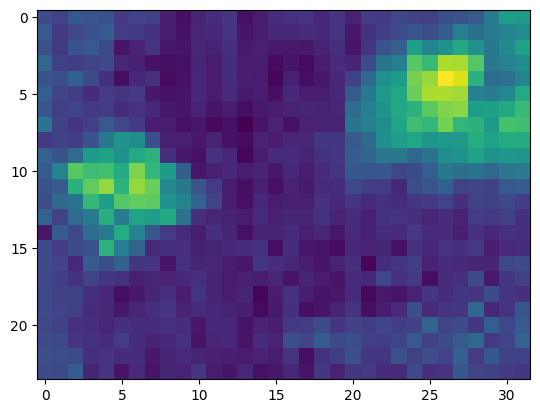

In [5]:
plt.imshow(dataset['images'][0])
print(dataset['bboxes'][0])
print(dataset['images'].max(), dataset['images'].min())

(24, 32, 1)
24
32
bbox:  tf.Tensor(
[[ 1  7 11 17]
 [19  2 29 11]
 [25  0 32  5]
 [25  5 32 12]], shape=(4, 4), dtype=int64)


2024-04-16 10:00:33.002497: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20889 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1d:00.0, compute capability: 8.6
2024-04-16 10:00:33.002742: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 21939 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1f:00.0, compute capability: 8.6
2024-04-16 10:00:33.002963: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 21939 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:20:00.0, compute capability: 8.6
2024-04-16 10:00:33.003202: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 21939 MB memory:  -> device: 3, name: NVIDIA GeForce RTX 3090

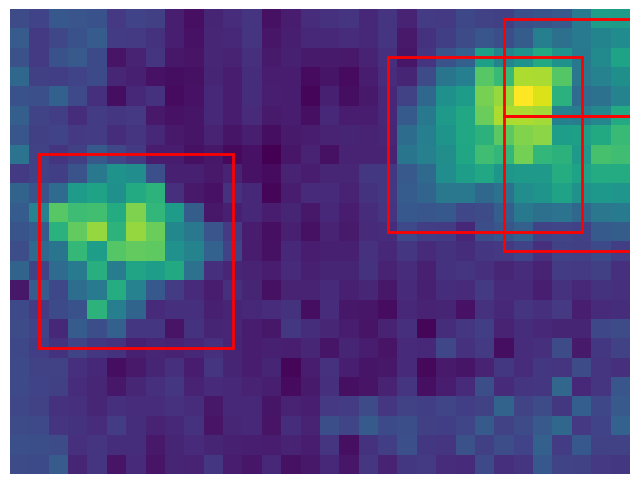

[[1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 ...
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]]


In [6]:
import matplotlib.pyplot as plt
import tensorflow as tf
images = dataset['images']
bboxes = dataset['bboxes']
cls = dataset['class']

boxes = bboxes
plt.figure(figsize = (8, 8))
plt.axis('off')
image = images
print(image[0].shape)
print(image[0].shape[0])
print(image[0].shape[1])
plt.imshow(image[0])
ax = plt.gca()
boxes = boxes[0]
boxes = tf.stack([
	(boxes[:, 0] ), 
	(boxes[:, 1] ),
	(boxes[:, 2] ),
	(boxes[:, 3] )], axis = -1
)
print("bbox: ", boxes)
# 각 바운딩 박스에 대해 반복하여 그리기
for box in boxes:
    xmin, ymin, xmax, ymax = box 
    w, h = xmax - xmin, ymax - ymin
    patch = plt.Rectangle(
        [xmin, ymin], w, h, fill=False, edgecolor=[1, 0, 0], linewidth=2
    )
    ax.add_patch(patch)
plt.show()
print(cls)

In [7]:
images.max(), images.min()

(255, 0)

In [8]:
import os
import random
import tensorflow as tf

IMG_SIZE_WIDTH = images.shape[2]
IMG_SIZE_HEIGHT = images.shape[1]
N_DATA = images.shape[0]
N_VAL = int(images.shape[0] * 0.2)
N_TRAIN = int(images.shape[0] - N_VAL)

cur_dir = os.getcwd()
tfr_dir = os.path.join(cur_dir, 'test/tfrecord/')
os.makedirs(tfr_dir, exist_ok=True)

tfr_train_dir = os.path.join(tfr_dir, 'od_train.tfr')
tfr_val_dir = os.path.join(tfr_dir, 'od_val.tfr')

print("IMG_SIZE_WIDTH:  ", IMG_SIZE_WIDTH)
print("IMG_SIZE_HEIGHT: ", IMG_SIZE_HEIGHT)
print("N_DATA:          ", N_DATA)
print("N_TRAIN:         ", N_TRAIN)
print("N_VAL:           ", N_VAL)

shuffle_list = list(range(N_DATA))
random.shuffle(shuffle_list)

train_idx_list = shuffle_list[:N_TRAIN]
val_idx_list = shuffle_list[N_TRAIN:]

tfr_train_dir = os.path.join(tfr_dir, 'od_train.tfr')
tfr_val_dir = os.path.join(tfr_dir, 'od_val.tfr')

writer_train = tf.io.TFRecordWriter(tfr_train_dir)
writer_val = tf.io.TFRecordWriter(tfr_val_dir)

IMG_SIZE_WIDTH:   32
IMG_SIZE_HEIGHT:  24
N_DATA:           828
N_TRAIN:          663
N_VAL:            165


In [9]:
def _bytes_feature(value):
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()
    return tf.train.Feature(bytes_list = tf.train.BytesList(value = [value]))

def _float_feature(value):
    return tf.train.Feature(float_list = tf.train.FloatList(value = value))

def _int64_feature(value):
    return tf.train.Feature(int32_list = tf.train.Int64List(value = [value]))


def _bytes_feature_list(value_list):
    """value_list가 리스트일 때, 이를 serialize하여 bytes list로 변환하는 함수."""
    value_list = [tf.io.serialize_tensor(tf.constant(v)).numpy() for v in value_list]
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=value_list))


In [10]:
dataset['images'] = dataset['images']
dataset['bboxes'] = dataset['bboxes']
dataset['class'] = np.array(dataset['class'])
images = dataset['images']
bboxes = dataset['bboxes']
cls = dataset['class']
print(images.shape)
print(bboxes.shape)
print(cls.shape)


(828, 24, 32, 1)
(828, 4, 4)
(828, 4)


In [11]:
for idx in train_idx_list:
    bbox = bboxes[idx]
    xmin, ymin, xmax, ymax = bbox[:, 0] / RES_WIDTH, bbox[:, 1] / RES_HEIGHT, bbox[:, 2] / RES_WIDTH, bbox[:, 3] / RES_HEIGHT
    bbox = np.stack([xmin, ymin, xmax, ymax], axis=-1).flatten()

    image = images[idx]
    bimage = image.tobytes()

    number = numbers[idx]
    class_id = cls[idx]
    # print(len(cls))
    serialized_cls = tf.io.serialize_tensor(tf.constant(class_id)).numpy()

    example = tf.train.Example(features=tf.train.Features(feature={
        'image': _bytes_feature(bimage),
        'bbox': _float_feature(bbox),
        'label': _bytes_feature(serialized_cls),
        # 'number': _int64_feature(number)
    }))
    
    writer_train.write(example.SerializeToString())
writer_train.close()


In [12]:
for idx in val_idx_list:
    bbox = bboxes[idx]
    xmin, ymin, xmax, ymax = bbox[:, 0] / RES_WIDTH, bbox[:, 1] / RES_HEIGHT, bbox[:, 2] / RES_WIDTH, bbox[:, 3] / RES_HEIGHT
    bbox = np.stack([xmin, ymin, xmax, ymax], axis=-1).flatten()

    image = images[idx]
    bimage = image.tobytes()

    number = numbers[idx]
    class_id = cls[idx]
    # print(len(cls))
    serialized_cls = tf.io.serialize_tensor(tf.constant(class_id)).numpy()

    example = tf.train.Example(features=tf.train.Features(feature={
        'image': _bytes_feature(bimage),
        'bbox': _float_feature(bbox),
        'label': _bytes_feature(serialized_cls),
        # 'number': _int64_feature(number)
    }))
    
    writer_val.write(example.SerializeToString())
writer_val.close()


In [13]:
AUTOTUNE = tf.data.AUTOTUNE

N_BATCH = 1
# LR = 0.0005


def _parse_function(tfrecord_serialized):
    features = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'bbox': tf.io.VarLenFeature(tf.float32),  
        'label': tf.io.FixedLenFeature([], tf.string),
        # 'number': tf.io.FixedLenFeature([], tf.int64)
    }

    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)

    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)
    image = tf.reshape(image, [RES_HEIGHT, RES_WIDTH, 1])
    image = tf.cast(image, tf.float32) 
    # image = image / tf.reduce_max(image)

    bbox = tf.sparse.to_dense(parsed_features['bbox']) 
    bbox = tf.cast(bbox, tf.float32)
    # num_boxes = tf.shape(bbox)[0] // 4
    bbox = tf.reshape(bbox, [-1, 4])

    serialized_cls = parsed_features['label']
    label = tf.io.parse_tensor(serialized_cls, out_type=tf.int64)
    
    # number = tf.cast(parsed_features['number'], tf.int64)
    return image, bbox, label



train_dataset = tf.data.TFRecordDataset(tfr_train_dir)
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=N_TRAIN).prefetch(AUTOTUNE).batch(N_BATCH, drop_remainder=True)

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

N_BATCH = 1
# LR = 0.0005


def _parse_function(tfrecord_serialized):
    features = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'bbox': tf.io.VarLenFeature(tf.float32),  
        'label': tf.io.FixedLenFeature([], tf.string),
        # 'number': tf.io.FixedLenFeature([], tf.int64)
    }

    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)

    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)
    image = tf.reshape(image, [RES_HEIGHT, RES_WIDTH, 1])
    image = tf.cast(image, tf.float32) 
    # image = image / tf.reduce_max(image)

    bbox = tf.sparse.to_dense(parsed_features['bbox']) 
    bbox = tf.cast(bbox, tf.float32)
    # num_boxes = tf.shape(bbox)[0] // 4
    bbox = tf.reshape(bbox, [-1, 4])

    serialized_cls = parsed_features['label']
    label = tf.io.parse_tensor(serialized_cls, out_type=tf.int64)
    
    # number = tf.cast(parsed_features['number'], tf.int64)
    return image, bbox, label



val_dataset = tf.data.TFRecordDataset(tfr_val_dir)
val_dataset = val_dataset.map(_parse_function, num_parallel_calls=AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size=N_TRAIN).prefetch(AUTOTUNE).batch(N_BATCH, drop_remainder=True)

In [15]:
for img, bbox, label in val_dataset.take(1):
    print(img.shape)
    print(bbox)
    print(label)

(1, 24, 32, 1)
tf.Tensor(
[[[0.         0.625      0.25       1.        ]
  [0.34375    0.625      0.625      1.        ]
  [0.3125     0.125      0.625      0.41666666]
  [0.34375    0.375      0.625      0.6666667 ]]], shape=(1, 4, 4), dtype=float32)
tf.Tensor([[1 1 1 1]], shape=(1, 4), dtype=int64)


(24, 32, 1)
tf.Tensor([1 1 1 1], shape=(4,), dtype=int64)
tf.Tensor(
[[0.5625     0.625      0.84375    1.        ]
 [0.0625     0.625      0.375      1.        ]
 [0.84375    0.08333334 1.         0.5416667 ]
 [0.625      0.08333334 0.84375    0.5416667 ]], shape=(4, 4), dtype=float32)


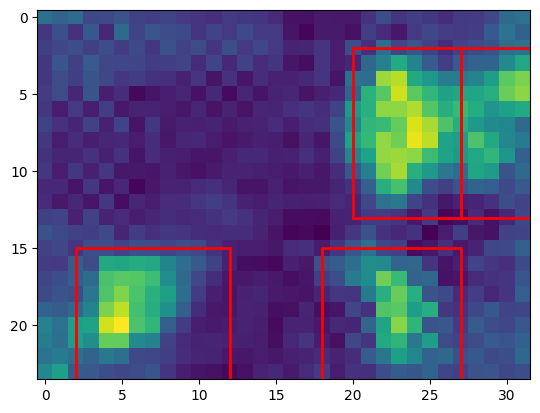

In [16]:
import matplotlib.pyplot as plt

idx = 0
for image, bbox, label in val_dataset.take(1):
    image = image[idx]
    bbox = bbox[idx]
    label = label[idx]
    image = image.numpy()
    plt.imshow(image)
    ax = plt.gca()  
    print(image.shape)
    print(label)
    print(bbox)
    boxes = tf.stack(
    	[
    	 bbox[:,0] * RES_WIDTH,
    	 bbox[:,1] * RES_HEIGHT,
    	 bbox[:,2] * RES_WIDTH,
    	 bbox[:,3] * RES_HEIGHT
    	], axis = -1
    )
    for box in boxes:
        xmin, ymin = box[:2]
        w, h = box[2:] - box[:2]
        patch = plt.Rectangle(
            [xmin, ymin], w, h, fill=False, edgecolor=[1, 0, 0], linewidth=2
        )
        ax.add_patch(patch)
    plt.show()

In [17]:
def convert_to_xywh(boxes):
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1
    )

def convert_to_corners(boxes):
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1
    )

In [18]:
def preprocess_data(image, gt_boxes, cls_ids):
    bbox = convert_to_xywh(gt_boxes)
    return image, bbox, cls_ids

In [19]:
for image, bbox, label in val_dataset.take(1):
    print(image.shape)
    print(bbox.shape)
    print(label.shape)

(1, 24, 32, 1)
(1, 4, 4)
(1, 4)


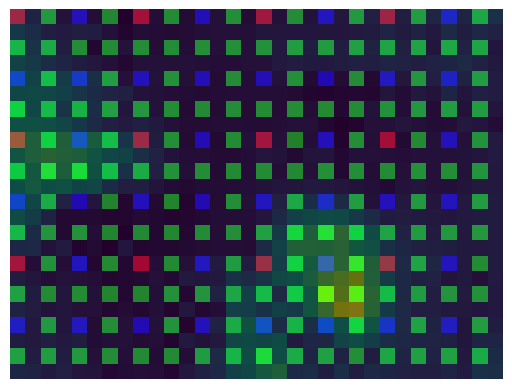

tf.Tensor(255.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)


In [20]:
idx = 0
for image, bbox, label in train_dataset.take(1):
    anchor_img = np.zeros((*image.shape[:3], 3), dtype=np.uint8)
    anchor_img = anchor_img[idx]

    strides = [2, 4, 8]
    colors = {
        2: [0, 255, 0],  # 초록색
        4: [0, 0, 255],  # 파란색
        8: [255, 0, 0],   # 빨간색
    }

    for stride in strides:
        color = colors[stride]
        for y in range(0, anchor_img.shape[0], stride):
            for x in range(0, anchor_img.shape[1], stride):
                anchor_img[y, x, :] = color

    # 이미지 표시
    plt.imshow(image[idx], alpha=1)  
    plt.imshow(anchor_img, alpha=0.5) 
    plt.axis('off')
    plt.show()
    print(tf.reduce_max(image), tf.reduce_min(image))

(24, 32, 1)
tf.Tensor(
[[0.203125   0.10416666 0.28125    0.20833333]
 [0.15625    0.33333334 0.3125     0.3333333 ]
 [0.125      0.6458334  0.25       0.20833331]
 [0.796875   0.39583334 0.28125    0.2916667 ]], shape=(4, 4), dtype=float32)
tf.Tensor([1 1 1 1], shape=(4,), dtype=int64)
tf.Tensor(251.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)
width:  32
height:  24
bbox:  tf.Tensor(
[[0.0625     0.         0.28125    0.20833333]
 [0.         0.16666669 0.3125     0.3333333 ]
 [0.         0.54166675 0.25       0.20833331]
 [0.65625    0.25       0.28125    0.2916667 ]], shape=(4, 4), dtype=float32)
tf.Tensor([0.0625     0.         0.28125    0.20833333], shape=(4,), dtype=float32)
tf.Tensor([0.         0.16666669 0.3125     0.3333333 ], shape=(4,), dtype=float32)
tf.Tensor([0.         0.54166675 0.25       0.20833331], shape=(4,), dtype=float32)
tf.Tensor([0.65625   0.25      0.28125   0.2916667], shape=(4,), dtype=float32)


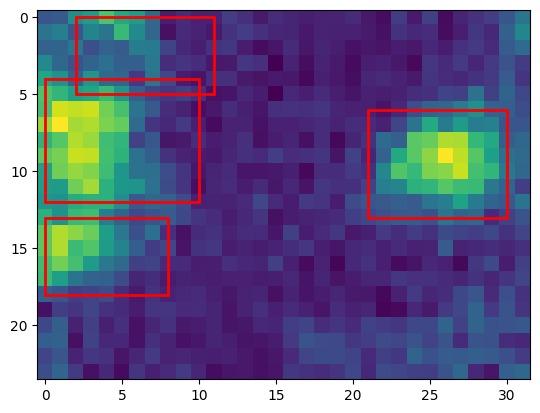

tf.Tensor([1 1 1 1], shape=(4,), dtype=int64)


In [21]:
idx = 0
for image, bbox, label in val_dataset.take(1):
    image, bbox, label = preprocess_data(image, bbox, label)
    img = image[idx]
    box = bbox[idx]
    label = label[idx]
    print(img.shape)
    print(box)
    print(label)
    print(tf.reduce_max(image), tf.reduce_min(image))
    # 이미지 시각화
    plt.imshow(img)
    ax = plt.gca()
    width = img.shape[1]
    height = img.shape[0]
    print("width: ", width)
    print("height: ", height)
    boxes = tf.stack(
        [
            (box[:, 0] - 0.5 * box[:, 2]),  # xmin = x_center - width/2
            (box[:, 1] - 0.5 * box[:, 3]),  # ymin = y_center - height/2
            box[:, 2],
            box[:, 3],
            
        ], axis=-1
    )
    print("bbox: ", boxes)
    # 각 바운딩 박스에 대해 반복하여 그리기
    for box in boxes:
        xmin, ymin, w, h = box
        print(box)
        patch = plt.Rectangle(
            [xmin * RES_WIDTH, ymin * RES_HEIGHT], w * RES_WIDTH, h * RES_HEIGHT, fill=False, edgecolor=[1, 0, 0], linewidth=2
        )
        ax.add_patch(patch)
    plt.show()
    print(label)
 

(24, 32, 1)
tf.Tensor(
[[0.453125  0.8333334 0.15625   0.3333333]
 [0.65625   0.7708333 0.25      0.375    ]
 [0.890625  0.7083333 0.21875   0.25     ]
 [0.09375   0.1875    0.1875    0.375    ]], shape=(4, 4), dtype=float32)
tf.Tensor([1 1 1 1], shape=(4,), dtype=int64)
tf.Tensor(255.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)


width:  32
height:  24
bbox:  tf.Tensor(
[[0.375      0.66666675 0.15625    0.3333333 ]
 [0.53125    0.5833333  0.25       0.375     ]
 [0.78125    0.5833333  0.21875    0.25      ]
 [0.         0.         0.1875     0.375     ]], shape=(4, 4), dtype=float32)
tf.Tensor([0.375      0.66666675 0.15625    0.3333333 ], shape=(4,), dtype=float32)
tf.Tensor([0.53125   0.5833333 0.25      0.375    ], shape=(4,), dtype=float32)
tf.Tensor([0.78125   0.5833333 0.21875   0.25     ], shape=(4,), dtype=float32)
tf.Tensor([0.     0.     0.1875 0.375 ], shape=(4,), dtype=float32)


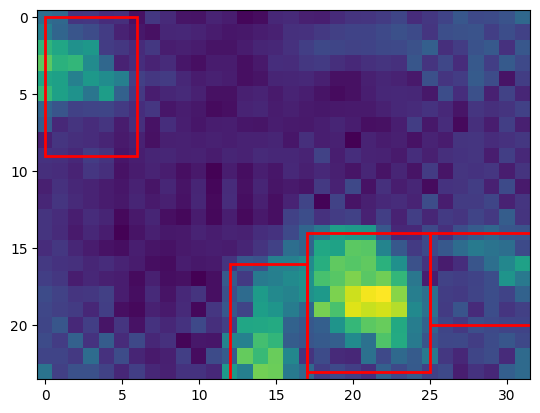

tf.Tensor([1 1 1 1], shape=(4,), dtype=int64)


In [22]:
idx = 0
for image, bbox, label in train_dataset.take(1):
    image, bbox, label = preprocess_data(image, bbox, label)
    img = image[idx]
    box = bbox[idx]
    label = label[idx]
    print(img.shape)
    print(box)
    print(label)
    print(tf.reduce_max(image), tf.reduce_min(image))
    # 이미지 시각화
    plt.imshow(img)
    ax = plt.gca()
    width = img.shape[1]
    height = img.shape[0]
    print("width: ", width)
    print("height: ", height)
    boxes = tf.stack(
        [
            (box[:, 0] - 0.5 * box[:, 2]),  # xmin = x_center - width/2
            (box[:, 1] - 0.5 * box[:, 3]),  # ymin = y_center - height/2
            box[:, 2],
            box[:, 3],
            
        ], axis=-1
    )
    print("bbox: ", boxes)
    # 각 바운딩 박스에 대해 반복하여 그리기
    for box in boxes:
        xmin, ymin, w, h = box
        print(box)
        patch = plt.Rectangle(
            [xmin * RES_WIDTH, ymin * RES_HEIGHT], w * RES_WIDTH, h * RES_HEIGHT, fill=False, edgecolor=[1, 0, 0], linewidth=2
        )
        ax.add_patch(patch)
    plt.show()
    print(label)
 

In [23]:
import numpy as np
from sklearn.cluster import KMeans

def compute_anchor_boxes(bboxes, img_width, img_height):
    all_bboxes = []
    for image_bboxes in bboxes:
        # 정규화된 좌표를 픽셀 단위 좌표로 변환
        pixel_bboxes = np.copy(image_bboxes)
        pixel_bboxes[:, 0] *= img_width
        pixel_bboxes[:, 1] *= img_height
        pixel_bboxes[:, 2] *= img_width
        pixel_bboxes[:, 3] *= img_height
        all_bboxes.extend(pixel_bboxes)
    
    all_bboxes = np.array(all_bboxes)
    
    # 높이가 0인 바운딩 박스 제거
    valid_bboxes = all_bboxes[np.logical_and(all_bboxes[:, 2] > all_bboxes[:, 0], all_bboxes[:, 3] > all_bboxes[:, 1])]
    
    box_sizes = valid_bboxes[:, 2:] - valid_bboxes[:, :2]
    box_ratios = box_sizes[:, 0] / box_sizes[:, 1]
    
    data = np.column_stack((box_sizes[:, 0], box_sizes[:, 1], box_ratios))
    
    kmeans = KMeans(n_clusters=4, random_state=0).fit(data)
    
    anchor_sizes = kmeans.cluster_centers_[:, :2]
    anchor_ratios = kmeans.cluster_centers_[:, 2]
    
    return anchor_sizes, anchor_ratios

bboxes = []
for image, image_bboxes, label in train_dataset:
    bboxes.append(image_bboxes.numpy())

# 이미지 너비와 높이 설정
img_width = 32
img_height = 24

anchor_sizes, anchor_ratios = compute_anchor_boxes(bboxes, img_width, img_height)
print("anchor_sizes (pixels): ", anchor_sizes)
print("anchor_ratios: ", anchor_ratios)

anchor_sizes (pixels):  [[ 5.910359  9.265604]
 [ 8.01403  13.074831]
 [ 5.771858  6.273226]
 [ 9.644481  9.19264 ]]
anchor_ratios:  [0.64572513 0.61533153 0.9401542  1.0799687 ]


In [24]:
class AnchorBox:
    def __init__(self):
        self.aspect_ratios = [0.7, 1.0]         # 이거랑 2268
        self.scales = [2** x for x in [1, 1.5]] # 이걸로 바운딩박스 갯수 조절가능
        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(0, 3)]
        self._areas = [x ** 2 for x in [3.5, 4.5, 5.5, 6.5, 7.5]]
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1),
                    [1, 1, 2]
                )
                dims = tf.cast(dims, tf.float32)  # 데이터 타입을 float32로 변환
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all
    
    def _get_anchors(self, feature_height, feature_width, level):
        rx = tf.range(feature_width, dtype = tf.float32) + 0.5
        ry = tf.range(feature_height, dtype = tf.float32) + 0.5

        centers = tf.stack(tf.meshgrid(rx, ry), axis = -1) * self._strides[level - 0] # stride시작점에 따라 바꿔야함 
        centers = tf.expand_dims(centers, axis = -2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])

        dims = tf.tile(
            self._anchor_dims[level - 0], [feature_height, feature_width, 1, 1] 
        )

        anchors = tf.concat([centers, dims], axis=-1) 

        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i), # 올림
                tf.math.ceil(image_width / 2 ** i),
                i
            )
            for i in range(0, 3)
        ]

        return tf.concat(anchors, axis=0)

Anchor 음수 값: False
tf.Tensor(
[[ 0.5        0.5        5.8566203  8.3666   ]
 [ 0.5        0.5        8.282512  11.832159 ]
 [ 0.5        0.5        7.         7.       ]
 ...
 [30.        22.        13.015375  18.593393 ]
 [30.        22.        11.        11.       ]
 [30.        22.        15.556349  15.556349 ]], shape=(4032, 4), dtype=float32)
(4032, 4)
(24, 32, 1)
[[0.140625   0.8125     0.30935922 0.41247895]
 [0.234375   0.7291667  0.21875    0.29166666]
 [0.484375   0.14583333 0.21875    0.29166666]
 [0.515625   0.27083334 0.21875    0.29166666]
 [0.171875   0.22916667 0.21875    0.29166666]
 [0.96875    0.20833333 0.28125    0.375     ]
 [0.15625    0.29166666 0.28125    0.375     ]
 [0.578125   0.14583333 0.30935922 0.41247895]
 [0.203125   0.7708333  0.18301938 0.34860834]
 [0.765625   0.3125     0.21875    0.29166666]
 [0.046875   0.22916667 0.18301938 0.34860834]
 [0.140625   0.4375     0.18301938 0.34860834]
 [0.921875   0.0625     0.2588285  0.49300662]
 [0.578125   0.6

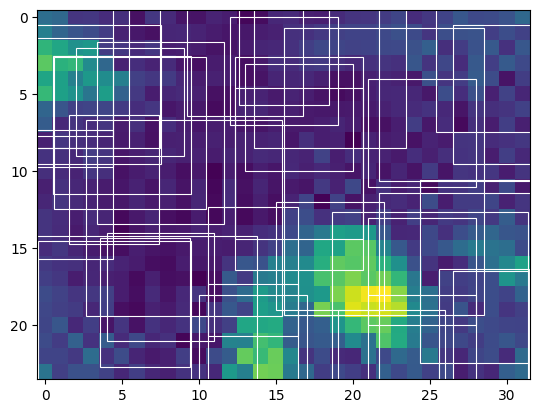

In [25]:
anchors = AnchorBox()
anchor = anchors.get_anchors(24, 32)

# 앵커 박스 정규화
xmin = anchor[:, 0] / RES_WIDTH
ymin = anchor[:, 1] / RES_HEIGHT
xmax = anchor[:, 2] / RES_WIDTH
ymax = anchor[:, 3] / RES_HEIGHT

# 정규화된 좌표를 스택으로 결합
normalized_anchor = tf.stack([xmin, ymin, xmax, ymax], axis=-1)

has_negative_values = tf.reduce_any(tf.less(anchor, 0))
print("Anchor 음수 값:", has_negative_values.numpy())

print(anchor)
print(anchor.shape)
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_bounding_boxes(data, num_samples):
    fig, ax = plt.subplots()

    plt.imshow(img)
    print(img.shape)
    data_np = data.numpy()

    if len(data) > num_samples:
        sampled_indices = np.random.choice(len(data), num_samples, replace=False)
        sample_data = data_np[sampled_indices]
    else : 
        sample_data = data_np
    print(sample_data)
    for center_x, center_y, width, height in sample_data:
        top_left_x = center_x - width / 2
        top_left_y = center_y - height / 2

        rect = patches.Rectangle((top_left_x * RES_WIDTH, top_left_y * RES_HEIGHT), width * RES_WIDTH, height * RES_HEIGHT, linewidth=0.8, edgecolor='white', facecolor='none')
        ax.add_patch(rect)
    
    plt.show()

draw_bounding_boxes(normalized_anchor, 40)


In [26]:
def compute_iou(boxes1, boxes2):
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    print(boxes1_corners.shape)
    print(boxes2_corners.shape)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])  
    
    intersection = tf.maximum(rd - lu, 0.0)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = (boxes1_corners[:, 2] - boxes1_corners[:, 0]) * (boxes1_corners[:, 3] - boxes1_corners[:, 1])
    boxes2_area = (boxes2_corners[:, 2] - boxes2_corners[:, 0]) * (boxes2_corners[:, 3] - boxes2_corners[:, 1])
    union_area = tf.maximum(boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8)

    return intersection_area / union_area

In [27]:
GA = np.array([[50, 30, 70, 60], [50, 30, 70, 60]])  # 예: [xmin, ymin, xmax, ymax]
GT = np.array([[50, 30, 70, 60], [35, 45, 55, 75]])  # 예: [xmin, ymin, xmax, ymax]

print("GA.shape:", GA.shape)
print("GT.shape:", GT.shape)

GA_xywh = convert_to_xywh(GA)
print("GA (XYWH):", GA_xywh)

GT_xywh = convert_to_xywh(GT)
print("GT (XYWH):", GT_xywh)

iou = compute_iou(GA_xywh, GT_xywh)
print("IoU:", iou)
# GA = convert_to_corners(GA)
# print(GA)
# GT = convert_to_corners(GT)
# print(GT)

GA.shape: (2, 4)
GT.shape: (2, 4)
GA (XYWH): tf.Tensor(
[[60. 45. 20. 30.]
 [60. 45. 20. 30.]], shape=(2, 4), dtype=float64)
GT (XYWH): tf.Tensor(
[[60. 45. 20. 30.]
 [45. 60. 20. 30.]], shape=(2, 4), dtype=float64)
(2, 4)
(2, 4)


IoU: tf.Tensor(
[[1.         0.06666667]
 [1.         0.06666667]], shape=(2, 2), dtype=float64)


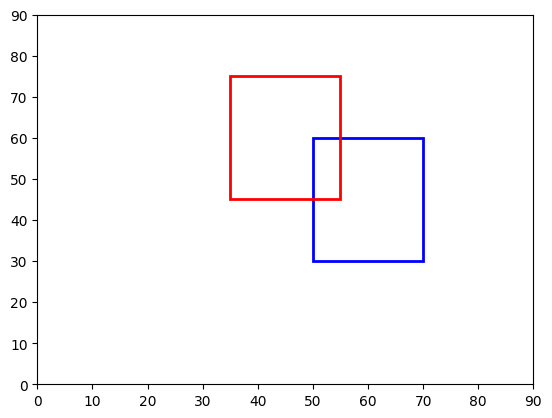

In [28]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# 주어진 바운딩 박스 데이터
box1 = [50, 30, 70, 60]  # [x_min, y_min, x_max, y_max]
box2 = [35, 45, 55, 75]

# 그림 생성
fig, ax = plt.subplots()

# 첫 번째 바운딩 박스 추가
rect1 = patches.Rectangle((box1[0], box1[1]), box1[2] - box1[0], box1[3] - box1[1], 
                          linewidth=2, edgecolor='blue', facecolor='none')
ax.add_patch(rect1)

# 두 번째 바운딩 박스 추가
rect2 = patches.Rectangle((box2[0], box2[1]), box2[2] - box2[0], box2[3] - box2[1], 
                          linewidth=2, edgecolor='red', facecolor='none')
ax.add_patch(rect2)

# 축 범위 설정
ax.set_xlim(0, 90)
ax.set_ylim(0, 90)

# 그림 표시
plt.show()



In [29]:
def match_anchor_boxes(anchor_boxes, gt_boxes, match_iou = 0.5, ignore_iou = 0.4):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        print("iou_matrix:  ", iou_matrix)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        print("max_iou:  ", max_iou)


        matched_gt_idx = tf.argmax(iou_matrix, axis = 1)
        print("matched_gt_idx:  ", matched_gt_idx)
    
        positive_mask = tf.greater_equal(max_iou, match_iou)
        print("positive_mask:  ", positive_mask)
        negative_mask = tf.less(max_iou, ignore_iou)
        print("negative_mask:  ", negative_mask)

        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        print("ignore_mask:  ", ignore_mask)
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype = tf.float32),
            tf.cast(ignore_mask, dtype = tf.float32),
        )
        

In [30]:
anchor = np.array([
                    [27.,  18.5,  8.,   7.],
                    [18.5, 15.5, 11.,   7.],
                    [ 6.,   4.,   8.,   6.],
                    [ 0.,   0.,   0.,   0.],
                    [ 1., 1., 4.242641, 8.485281 ],
                    [ 1.,         1.,         5.3453927, 10.690784 ],
                    [ 1.,         1.,         6.7347727, 13.469543 ],
                    [30.,        22.,         9.899496,   4.949747 ]])

gt_boxes = np.array([[27.,  18.5,  8.,   7., ],
                     [18.5, 15.5, 11.,   7. ],
                     [ 6.,   4.,   8.,   6. ],
                     [ 0.,   0.,   0.,   0. ]])
# print(gt_boxes.shape)
a, b, c = match_anchor_boxes(tf.cast(anchor, tf.float32), tf.cast(gt_boxes, tf.float32))

(8, 4)
(4, 4)


iou_matrix:   tf.Tensor(
[[1.         0.03100775 0.         0.        ]
 [0.03100775 1.         0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.06003535 0.        ]
 [0.         0.         0.09293901 0.        ]
 [0.         0.         0.11408175 0.        ]
 [0.16311106 0.         0.         0.        ]], shape=(8, 4), dtype=float32)
max_iou:   tf.Tensor(
[1.         1.         1.         0.         0.06003535 0.09293901
 0.11408175 0.16311106], shape=(8,), dtype=float32)
matched_gt_idx:   tf.Tensor([0 1 2 0 2 2 2 0], shape=(8,), dtype=int64)
positive_mask:   tf.Tensor([ True  True  True False False False False False], shape=(8,), dtype=bool)
negative_mask:   tf.Tensor([False False False  True  True  True  True  True], shape=(8,), dtype=bool)
ignore_mask:   tf.Tensor([False False False False False False False False], shape=(8,), dtype=bool)


In [31]:
class LabelEncoder:
    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32)
    
    def _match_anchor_boxes(self, anchor_boxes, gt_boxes, match_iou = 0.5, ignore_iou = 0.4):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        print("iou_matrix:  ", iou_matrix.shape)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        print("max_iou:  ", max_iou.shape)

        matched_gt_idx = tf.argmax(iou_matrix, axis = 1)
        print("matched_gt_idx:  ", matched_gt_idx)
        print("max_iou:", max_iou)
        positive_mask = tf.greater_equal(max_iou, match_iou)
        print("positive_mask:  ", positive_mask)
        negative_mask = tf.less(max_iou, ignore_iou)
        print("negative_mask:  ", negative_mask.shape)

        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        print("ignore_mask:  ", ignore_mask.shape)
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype = tf.float32),
            tf.cast(ignore_mask, dtype = tf.float32),
        )
    
    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        print("_compute_box_target anchor_boxes: ", anchor_boxes)
        print("_compute_box_target matched_gt_boxes : ", matched_gt_boxes)
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:])
            ],
            axis = -1,
        )
        print("box_target:  ", box_target)
        box_target = box_target / self._box_variance
        print("box_target:  ", box_target)
        return box_target
    

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):        
        print("image_shape:", image_shape.shape)
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        # 앵커 박스 정규화
        xmin = anchor_boxes[:, 0] / RES_WIDTH
        ymin = anchor_boxes[:, 1] / RES_HEIGHT
        xmax = anchor_boxes[:, 2] / RES_WIDTH
        ymax = anchor_boxes[:, 3] / RES_HEIGHT

        # 정규화된 좌표를 스택으로 결합
        normalized_anchor = tf.stack([xmin, ymin, xmax, ymax], axis=-1)
        
        print("anchor_boxes  : ", normalized_anchor)
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        print("cls_ids", cls_ids)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            normalized_anchor, gt_boxes
        )
        print("matched_gt_idx:  ", matched_gt_idx)
        print("positive_mask:  ", positive_mask)
        print("ignore_mask:  ", ignore_mask)

        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)

        print("matched_gt_boxes:  ", matched_gt_boxes)
        
        box_target = self._compute_box_target(normalized_anchor, matched_gt_boxes)
        print("box_target:  ", box_target)

        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        print("matched_gt_cls_ids:  ", matched_gt_cls_ids)
        
        cls_target = tf.where(tf.cast(positive_mask, tf.bool), matched_gt_cls_ids, -1.0)
        cls_target = tf.where(tf.cast(ignore_mask, tf.bool), -2.0, cls_target)

        print("cls_target:  ", cls_target)

        cls_target = tf.expand_dims(cls_target, axis=-1)
        print("cls_target:  ", cls_target)
        num_ones = tf.math.count_nonzero(tf.equal(cls_target, 1.0))
        print("Number of 1.0 values in cls_target:", num_ones)


        label = tf.concat([box_target, cls_target], axis=-1)
        print("label:  ", label)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):       
        images_shape = tf.shape(batch_images)
        print("images_shape:  ", images_shape)
        batch_size = images_shape[0]
        print("batch_size:  ", batch_size)

        print("gt_boxes: ", gt_boxes)

        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        print("labels:  ", labels)
        # batch_size_val = batch_size.numpy()
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            print("label:  ", label)
            labels = labels.write(i, label)
        return batch_images, labels.stack()

In [32]:
print("Eager execution: ", tf.executing_eagerly())
if not tf.executing_eagerly():
    tf.compat.v1.enable_eager_execution()

Eager execution:  True


In [33]:
label_encoder = LabelEncoder()

for image, bbox, label in train_dataset.take(1):
    img, box, label = preprocess_data(image, bbox, label)
    print(img.shape, box.shape, label.shape)

    label_encoder.encode_batch(img, box, label)
    

(1, 24, 32, 1) (1, 4, 4) (1, 4)
images_shape:   tf.Tensor([ 1 24 32  1], shape=(4,), dtype=int32)
batch_size:   tf.Tensor(1, shape=(), dtype=int32)
gt_boxes:  tf.Tensor(
[[[0.203125   0.875      0.28125    0.25      ]
  [0.671875   0.7291667  0.21875    0.375     ]
  [0.203125   0.5625     0.34375    0.29166666]
  [0.171875   0.2916667  0.28125    0.33333334]]], shape=(1, 4, 4), dtype=float32)
labels:   <tensorflow.python.ops.tensor_array_ops.TensorArray object at 0x7f3110289f70>
image_shape: (4,)
anchor_boxes  :  tf.Tensor(
[[0.015625   0.02083333 0.18301938 0.34860834]
 [0.015625   0.02083333 0.2588285  0.49300662]
 [0.015625   0.02083333 0.21875    0.29166666]
 ...
 [0.9375     0.9166667  0.40673047 0.7747247 ]
 [0.9375     0.9166667  0.34375    0.45833334]
 [0.9375     0.9166667  0.4861359  0.6481812 ]], shape=(4032, 4), dtype=float32)
cls_ids tf.Tensor([1. 1. 1. 1.], shape=(4,), dtype=float32)
(4032, 4)
(4, 4)
iou_matrix:   (4032, 4)
max_iou:   (4032,)
matched_gt_idx:   tf.Tensor(

In [34]:
label_encoder = LabelEncoder()

autotune = tf.data.AUTOTUNE
train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=autotune)

In [35]:
for img, bbox, label in train_dataset.take(1):
    print(img.shape)
    print(bbox.shape)
    print(label.shape)

(1, 24, 32, 1)
(1, 4, 4)
(1, 4)


In [36]:
train_dataset = train_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)

images_shape:   Tensor("Shape:0", shape=(4,), dtype=int32)
batch_size:   Tensor("strided_slice:0", shape=(), dtype=int32)
gt_boxes:  Tensor("args_1:0", shape=(1, None, 4), dtype=float32)
labels:   <tensorflow.python.ops.tensor_array_ops.TensorArray object at 0x7f32f0d4b430>
image_shape: (4,)
anchor_boxes  :  Tensor("while/stack_3:0", shape=(None, 4), dtype=float32)
cls_ids Tensor("while/Cast:0", dtype=float32)
(None, 4)
(None, 4)
iou_matrix:   (None, None)
max_iou:   (None,)
matched_gt_idx:   Tensor("while/ArgMax:0", shape=(None,), dtype=int64)
max_iou: Tensor("while/Max:0", shape=(None,), dtype=float32)
positive_mask:   Tensor("while/GreaterEqual:0", shape=(None,), dtype=bool)
negative_mask:   (None,)
ignore_mask:   (None,)
matched_gt_idx:   Tensor("while/ArgMax:0", shape=(None,), dtype=int64)
positive_mask:   Tensor("while/Cast_1:0", shape=(None,), dtype=float32)
ignore_mask:   Tensor("while/Cast_2:0", shape=(None,), dtype=float32)
matched_gt_boxes:   Tensor("while/GatherV2:0", shape

In [37]:
positive_count = []
negative_count = []
ignore_count = []
for batch in train_dataset.take(3):
    images, labels = batch
    print(np.array(images).max(), np.array(images).min())
    print(labels.shape)

    # labels 텐서에서 positive, negative, ignore 값의 개수를 계산
    positive_count = tf.reduce_sum(tf.cast(tf.equal(labels[0, :, 4], 1.0), tf.int32))
    negative_count = tf.reduce_sum(tf.cast(tf.equal(labels[0, :, 4], -1.0), tf.int32))
    ignore_count = tf.reduce_sum(tf.cast(tf.equal(labels[0, :, 4], -2.0), tf.int32))

    print("Positive 개수:", positive_count.numpy())
    print("Negative 개수:", negative_count.numpy())
    print("Ignore 개수:", ignore_count.numpy())


253.0 0.0
(1, 4032, 5)
Positive 개수: 156
Negative 개수: 3697
Ignore 개수: 179
255.0 2.0
(1, 4032, 5)
Positive 개수: 233
Negative 개수: 3575
Ignore 개수: 224
255.0 0.0
(1, 4032, 5)
Positive 개수: 214
Negative 개수: 3583
Ignore 개수: 235


Positive 개수: 149
Negative 개수: 3485
Ignore 개수: 398
Positive 149


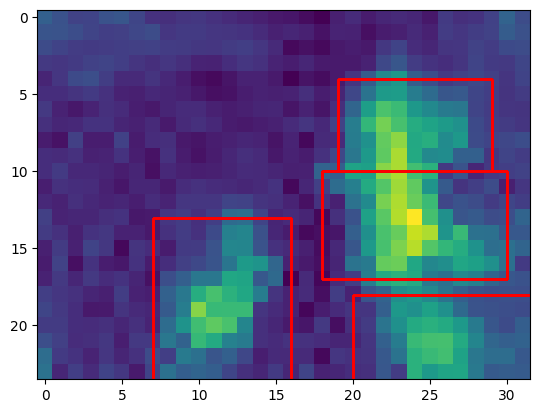

In [38]:
def decode_predictions(labels, anchors, box_variance=[0.1, 0.1, 0.2, 0.2]):
    decoded_boxes = []
    label_idx = 0
    for label in labels:
        # if label[4] == 1.0:
        #     print("label:", label)
        # elif label[4] == -1.0:
        #     print("label:", label)
        dx, dy, dw, dh = label[:4]
        anchor = anchors[label_idx]
        anchor_x, anchor_y, anchor_w, anchor_h = anchor
        cx = dx * box_variance[0] * anchor_w + anchor_x
        cy = dy * box_variance[1] * anchor_h + anchor_y
        width = np.exp(dw * box_variance[2]) * anchor_w
        height = np.exp(dh * box_variance[3]) * anchor_h
        x_min = cx - width / 2
        y_min = cy - height / 2
        decoded_box = [x_min, y_min, width, height]
        # print(np.array(decoded_box))
        if label[4] == 1.0:
            decoded_boxes.append(decoded_box)
        label_idx += 1
        # if len(np.array(decoded_boxes)) > 1: 
            # break
    print("Positive",len(np.array(decoded_boxes)))
    return decoded_boxes    
    # print(np.array(decoded_boxes))
    

# 바운딩 박스 그리기 함수
def draw_positive_bounding_boxes(image, decoded_boxes):
    plt.imshow(image)
    ax = plt.gca()
    # print(len(decoded_boxes))
    i = 0
    for box in decoded_boxes:
        i+=1
        # print(box)
        x_min, y_min, width, height = box
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    # print(i)
    plt.show()

# 앵커 박스 생성
anchor_box = AnchorBox()
anchors = anchor_box.get_anchors(24, 32)
# train_dataset에서 첫 번째 배치를 가져오고, 바운딩 박스 그리기
for batch in train_dataset.take(1):
    image = batch[0][0].numpy()
    labels = batch[1][0].numpy()  # 여기서 labels는 [오프셋x, 오프셋y, 스케일w, 스케일h, 클래스, 앵커 박스 인덱스]를 포함한다고 가정
    # print(labels)
    positive_count = tf.reduce_sum(tf.cast(tf.equal(labels[:, 4], 1.0), tf.int32))
    negative_count = tf.reduce_sum(tf.cast(tf.equal(labels[:, 4], -1.0), tf.int32))
    ignore_count = tf.reduce_sum(tf.cast(tf.equal(labels[:, 4], -2.0), tf.int32))

    print("Positive 개수:", positive_count.numpy())
    print("Negative 개수:", negative_count.numpy())
    print("Ignore 개수:", ignore_count.numpy())

    # 오프셋 디코딩 및 바운딩 박스 그리기
    decoded_boxes = decode_predictions(labels, anchors)
    draw_positive_bounding_boxes(image, decoded_boxes)

In [39]:
class DepthwiseSeparableConv(layers.Layer):
    def __init__(self, out_channels, kernel_size, stride=1, padding=0):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = layers.DepthwiseConv2D(kernel_size=kernel_size, padding='same' if padding else 'valid', depth_multiplier=1, strides=stride, kernel_initializer=tf.keras.initializers.HeNormal())
        self.pointwise = layers.Conv2D(out_channels, kernel_size=1, strides=1, kernel_initializer=tf.keras.initializers.HeNormal())

    def call(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out

class DepthwiseConv(layers.Layer):
    def __init__(self, out_channels, kernel_size=3, stride=1, padding=1):
        super(DepthwiseConv, self).__init__()
        self.depthwise = DepthwiseSeparableConv(out_channels, kernel_size, stride, padding)
        self.batch_norm = layers.BatchNormalization()
        self.selu = layers.Activation('selu')

    def call(self, x):
        out = self.depthwise(x)
        out = self.batch_norm(out)
        out = self.selu(out)
        return out

In [40]:
class Conv(layers.Layer):
    def __init__(self, out_channels, kernel_size=3, stride=2, padding='SAME'):
        super(Conv, self).__init__()
        self.conv = layers.Conv2D(out_channels, kernel_size, strides=stride, padding=padding, kernel_initializer=tf.keras.initializers.HeNormal())
        self.batch_norm = layers.BatchNormalization()
        self.relu = layers.ReLU()

    def call(self, x):
        x = self.conv(x)
        x = self.batch_norm(x)
        return self.relu(x)

In [41]:
class Bottleneck(layers.Layer):
    def __init__(self, out_channels, stride=1):
        super(Bottleneck, self).__init__()
        self.conv_0 = layers.Conv2D(out_channels, kernel_size=1, strides=stride, padding='same', kernel_initializer=tf.keras.initializers.HeNormal())
        self.conv_1 = layers.Conv2D(out_channels, kernel_size=3, strides=stride, padding='same', kernel_initializer=tf.keras.initializers.HeNormal())
        self.batch_norm_0 = layers.BatchNormalization()
        self.batch_norm_1 = layers.BatchNormalization()
        self.relu = layers.ReLU()

    def call(self, x):
        identity = x
        out = self.conv_0(x)
        out = self.batch_norm_0(out)
        out = self.relu(out)
        out = self.conv_1(out)
        out = self.batch_norm_1(out)
        out += identity
        return self.relu(out)

In [42]:
class ChannelAttention(layers.Layer):
    def __init__(self, pool_types=['avg', 'max'], kernel_size=3):
        super(ChannelAttention, self).__init__()
        self.pool_types = pool_types
        self.conv = layers.Conv2D(1, kernel_size=kernel_size, strides=1, padding='same', use_bias=False, kernel_initializer=tf.keras.initializers.HeNormal())
        self.sigmoid = layers.Activation('sigmoid')

    def call(self, x):
        pooled_features = []
        for pool_type in self.pool_types:
            if pool_type == 'avg':
                pooled = tf.reduce_mean(x, axis=[1, 2], keepdims=True)
            elif pool_type == 'max':
                pooled = tf.reduce_max(x, axis=[1, 2], keepdims=True)
            pooled_features.append(pooled)
        concat = tf.concat(pooled_features, axis=-1)
        attention = self.conv(concat)
        attention = self.sigmoid(attention)
        return x * attention

In [43]:
class SpatialAttention(layers.Layer):
    def __init__(self, kernel_size=3):
        super(SpatialAttention, self).__init__()
        self.conv = layers.Conv2D(1, kernel_size=kernel_size, strides=1, padding='same', use_bias=False, kernel_initializer=tf.keras.initializers.HeNormal())
        self.sigmoid = layers.Activation('sigmoid')

    def call(self, x):
        avg_out = tf.reduce_mean(x, axis=-1, keepdims=True)
        max_out = tf.reduce_max(x, axis=-1, keepdims=True)
        x = tf.concat([avg_out, max_out], axis=-1)
        x = self.conv(x)
        return self.sigmoid(x)

In [44]:
class CBAM(layers.Layer):
    def __init__(self, pool_types=['avg', 'max'], kernel_size=3):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(pool_types, kernel_size)
        self.spatial_attention = SpatialAttention(kernel_size)

    def call(self, x):
        x = self.channel_attention(x)
        x = self.spatial_attention(x) * x
        return x

In [45]:
from typing import List, Tuple
class SPPFast(layers.Layer):
    def __init__(self, filters: int, pool_kernel_sizes: List[int] = [1, 2, 4], **kwargs):
        super().__init__(**kwargs)
        self.pool_kernel_sizes = pool_kernel_sizes
        self.global_pool = layers.GlobalAveragePooling2D()
        self.conv = layers.Conv2D(filters, kernel_size=1, strides=1, padding='same', use_bias=False, kernel_initializer=tf.keras.initializers.HeNormal())

    def call(self, inputs: tf.Tensor) -> tf.Tensor:
        height, width = tf.shape(inputs)[1], tf.shape(inputs)[2]
        # 글로벌 평균 풀링과 업샘플링
        global_features = self.global_pool(inputs)
        global_features = tf.expand_dims(tf.expand_dims(global_features, 1), 1)
        global_features = tf.image.resize(global_features, [height, width])
        # 다양한 크기의 MaxPooling
        pooled_outputs = [
            layers.MaxPooling2D(pool_size=kernel_size, strides=1, padding='SAME')(inputs)
            for kernel_size in self.pool_kernel_sizes
        ]
        # 업샘플링 및 컨캐터네이션
        pooled_outputs = [
            tf.image.resize(pooled, [height, width])
            for pooled in pooled_outputs
        ]
        pooled_outputs.append(global_features)
        pooled_outputs.append(inputs)
        spp_output = tf.concat(pooled_outputs, axis=-1)
        # 컨볼루션 적용
        spp_output = self.conv(spp_output)
        return spp_output

In [46]:
# MultiStageFeatureExtractionLayer
class MSFELayer(layers.Layer):
    def __init__(self, sperate_input_channel, out_channel):
        super(MSFELayer, self).__init__()
        self.sppf = SPPFast(sperate_input_channel // 3)
        self.cbam = CBAM()
        self.bootleneck = Bottleneck(sperate_input_channel // 3)
        self.conv = Conv(out_channel, kernel_size=3, stride=1, padding='SAME')

    def call(self, x):
        sppf, cbam, bottle = tf.split(x, num_or_size_splits=3, axis=-1)
        sppf = self.sppf(sppf)
        cbam = self.cbam(cbam)
        bottle = self.bootleneck(bottle)

        out = tf.concat([sppf, cbam, bottle], axis = -1)
        out = self.conv(out)
        return out


In [47]:
class Upsample(layers.Layer):
    def __init__(self, out_channel, size, interpolation = 'bilinear'):
        super(Upsample, self).__init__()
        self.upsample = layers.UpSampling2D(size=size, interpolation = interpolation)
        self.conv = layers.Conv2D(out_channel, kernel_size = 1, strides = 1, padding='same', kernel_initializer=tf.keras.initializers.HeNormal())
    def call(self, inputs):
        out = self.upsample(inputs)
        out = self.conv(out)
        return out


In [48]:
class Conv2DTranspose(layers.Layer):
    def __init__(self, out_channel, size):
        super(Conv2DTranspose, self).__init__()
        self.transpose = layers.Conv2DTranspose(filters=out_channel, kernel_size=1, strides=size, padding='same', kernel_initializer=tf.keras.initializers.HeNormal())

    def call(self, x):
        return self.transpose(x)
    

In [49]:
class CSUpsample(layers.Layer):
    def __init__(self, out_channel, kernel_size, size, interpolation = 'bilinear'):
        super(CSUpsample, self).__init__()
        self.upsample = Upsample(out_channel, size=size, interpolation = interpolation)
        self.transpose = Conv2DTranspose(out_channel, size=size)
        self.conv = Conv(out_channel, kernel_size = kernel_size, stride=1, padding='SAME')
    
    def call(self, x):
        upsample, transpose = tf.split(x, num_or_size_splits=2, axis=-1)
        upsample = self.upsample(upsample)
        transpose = self.transpose(transpose)

        out = tf.concat([upsample, transpose], axis = -1)
        out = self.conv(out)
        return out

In [50]:
class BackBone(tf.keras.layers.Layer):
    def __init__(self):
        super(BackBone, self).__init__()
        self.conv1 = Conv(out_channels=6, kernel_size=3, stride=1)
        self.msfe1 = MSFELayer(6, 12)

        self.conv2 = Conv(out_channels=12, kernel_size=3, stride=2)
        self.msfe2 = MSFELayer(12, 18)

        self.conv3 = Conv(out_channels=18, kernel_size=3, stride=2)
        self.msfe3 = MSFELayer(18, 21)

        self.conv4 = Conv(out_channels=21, kernel_size=3, stride=2)
        self.msfe4 = MSFELayer(21, 24)
        # self.sppf = SPPFast(24)

    def call(self, inputs):
        p1 = self.conv1(inputs) # 24, 32
        p1_out = self.msfe1(p1)

        p2 = self.conv2(p1_out) # 12, 16
        p2_out = self.msfe2(p2)

        p3 = self.conv3(p2_out) # 6, 8
        p3_out = self.msfe3(p3)

        p4 = self.conv4(p3_out) # 3, 4
        p4_out = self.msfe4(p4)

        return p1_out, p2_out, p3_out, p4_out

In [51]:
class Neck(tf.keras.layers.Layer):
    def __init__(self):
        super(Neck, self).__init__()
        self.conv1 = Conv(20, kernel_size=1, stride=1)
        self.csupsample_c1 = CSUpsample(21, kernel_size=1, size=(2, 2))
        self.msfe_c1 = MSFELayer(42, 20)

        self.csupsample_c2 = CSUpsample(18, kernel_size=1, size=(2, 2))
        self.msfe_c2 = MSFELayer(36, 30)

        self.csupsample_c3 = CSUpsample(12, kernel_size=1, size=(2, 2))
        self.msfe_c3 = MSFELayer(24, 12)


#   • p1=tf.Tensor(shape=(None, 24, 32, 12), dtype=float32)
#   • p2=tf.Tensor(shape=(None, 12, 16, 18), dtype=float32)
#   • p3=tf.Tensor(shape=(None, 6, 8, 21), dtype=float32)
#   • p4=tf.Tensor(shape=(None, 3, 4, 24), dtype=float32)

    def call(self, p1, p2, p3, p4):
        c3 = self.conv1(p4) # 3, 4      
        c3 = self.csupsample_c1(c3)  # 6, 8
        c3 = layers.concatenate([c3, p3]) 
        c3_out = self.msfe_c1(c3)

        c2 = self.csupsample_c2(c3_out) # 12, 16
        c2 = layers.concatenate([c2, p2])  
        c2_out = self.msfe_c2(c2)

        c1 = self.csupsample_c3(c2_out) # 24, 32
        c1 = layers.concatenate([c1, p1]) 
        c1_out = self.msfe_c3(c1)

        return c1_out, c2_out, c3_out

In [52]:
class Head(tf.keras.layers.Layer):
    def __init__(self):
        super(Head, self).__init__()
        
        self.csupsample1 = CSUpsample(20, kernel_size = 1, size = 2)
        self.csupsample2 = CSUpsample(20, kernel_size = 1, size = 2)
        # FPN layers
        self.lateral_conv1 = layers.Conv2D(20, 1, padding='same', kernel_initializer=tf.keras.initializers.HeNormal(), use_bias=False)
        self.lateral_conv2 = layers.Conv2D(20, 1, padding='same', kernel_initializer=tf.keras.initializers.HeNormal(), use_bias=False)
        self.lateral_conv3 = layers.Conv2D(20, 1, padding='same', kernel_initializer=tf.keras.initializers.HeNormal(), use_bias=False)
        
        self.smooth_conv1 = layers.Conv2D(24, 3, padding='same', kernel_initializer=tf.keras.initializers.HeNormal(), use_bias=False)
        self.smooth_conv2 = layers.Conv2D(24, 3, padding='same', kernel_initializer=tf.keras.initializers.HeNormal(), use_bias=False)
        self.smooth_conv3 = layers.Conv2D(24, 3, padding='same', kernel_initializer=tf.keras.initializers.HeNormal(), use_bias=False)
        
#   • c1=tf.Tensor(shape=(None, 24, 32, 12), dtype=float32)
#   • c2=tf.Tensor(shape=(None, 12, 16, 12), dtype=float32)
#   • c3=tf.Tensor(shape=(None, 6, 8, 20), dtype=float32)

    def call(self, c1, c2, c3):
        lateral_conv1 = self.lateral_conv1(c1)
        lateral_conv2 = self.lateral_conv2(c2)
        lateral_conv3 = self.lateral_conv3(c3)

        fpn_out3 = lateral_conv3
        fpn_out2 = layers.Add()([self.csupsample1(fpn_out3), lateral_conv2])
        fpn_out1 = layers.Add()([self.csupsample2(fpn_out2), lateral_conv1])

        fpn_out1 = self.smooth_conv1(fpn_out1)
        fpn_out2 = self.smooth_conv2(fpn_out2)
        fpn_out3 = self.smooth_conv3(fpn_out3)
        
        return fpn_out1, fpn_out2, fpn_out3    

In [53]:
class DetectionModel(tf.keras.Model):
    def __init__(self, num_classes = 1, num_anchors_per_location = 4):
        super(DetectionModel, self).__init__()

        self.backbone = BackBone()
        self.neck = Neck()
        self.head = Head()

        self.prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        self.num_classes = num_classes
        self.num_anchors_per_location = num_anchors_per_location

        self.classification_head = tf.keras.Sequential([
            layers.Conv2D(24, 1, strides=1, padding='same', kernel_initializer=tf.keras.initializers.HeNormal(), use_bias=False),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv2D(32, 1, strides=1, padding='same', kernel_initializer=tf.keras.initializers.HeNormal(), use_bias=False),
            layers.Conv2D(num_anchors_per_location * num_classes, 1, padding="same", kernel_initializer=tf.keras.initializers.HeNormal(), use_bias=False),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Activation('sigmoid')
        ])
        
        self.regression_head = tf.keras.Sequential([
            layers.Conv2D(24, 1, strides=1, padding='same', kernel_initializer=tf.keras.initializers.HeNormal(), use_bias=False),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv2D(32, 1, strides=1, padding='same', kernel_initializer=tf.keras.initializers.HeNormal(), use_bias=False),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv2D(num_anchors_per_location * 4, 1, padding="same", kernel_initializer=tf.keras.initializers.HeNormal(), use_bias=False),
        ])

    def call(self, inputs):
        p1, p2, p3, p4 = self.backbone(inputs)
        c1, c2, c3 = self.neck(p1, p2, p3, p4)
        fpn_out1, fpn_out2, fpn_out3 = self.head(c1, c2, c3)

        cls_outputs = []
        reg_outputs = []
        N = tf.shape(inputs)[0]
        
        for _, feature in enumerate([fpn_out1, fpn_out2, fpn_out3]):
            cls_output = self.classification_head(feature)
            reg_output = self.regression_head(feature)
            
            H, W = feature.shape[1], feature.shape[2]
            num_anchors = H * W * self.num_anchors_per_location

            reg_output = tf.reshape(reg_output, [N, num_anchors, 4])
            cls_output = tf.reshape(cls_output, [N, num_anchors, self.num_classes])

            cls_outputs.append(cls_output)
            reg_outputs.append(reg_output)

        reg_outputs = tf.concat(reg_outputs, axis=1)
        cls_outputs = tf.concat(cls_outputs, axis=1)
        final_output = tf.concat([reg_outputs, cls_outputs], axis=-1)
        return final_output

In [54]:
model = DetectionModel(num_classes=1)
model.trainable = True
model.build(input_shape=(None, 24, 32, 1))
model.summary()

Model: "detection_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 back_bone (BackBone)        multiple                  21604     
                                                                 
 neck (Neck)                 multiple                  31143     
                                                                 
 head (Head)                 multiple                  16880     
                                                                 
 sequential (Sequential)     (None, None, None, 4)     1584      
                                                                 
 sequential_1 (Sequential)   (None, None, None, 16)    2080      
                                                                 
Total params: 73291 (286.29 KB)
Trainable params: 72301 (282.43 KB)
Non-trainable params: 990 (3.87 KB)
_________________________________________________________________


In [55]:
# class BoxLoss(tf.losses.Loss):
#     def __init__(self, delta):
#         super(BoxLoss, self).__init__(reduction="none", name="BoxLoss")
#         self._delta = delta

#     def call(self, y_true_box, y_pred_box):
#         difference = y_true_box - y_pred_box
#         absolute_difference = tf.abs(difference)
#         squared_difference = difference ** 2
#         loss = tf.where(
#             tf.less_equal(absolute_difference, self._delta),
#             0.5 * squared_difference,
#             absolute_difference - 0.5 * self._delta
#         )
#         return tf.reduce_sum(loss, axis=-1)  # 각 앵커에 대한 평균을 반환


# class CombinedBoxLoss(tf.losses.Loss):
#     def __init__(self, delta=2.0, weight_box=1.0, name="CombinedBoxLoss"):
#         super(CombinedBoxLoss, self).__init__(reduction="none", name=name)
#         self.box_loss = BoxLoss(delta=delta)
#         self.weight_box = weight_box

#     def call(self, y_true, y_pred, selected_mask=None):
#         if selected_mask is None:
#             selected_mask = tf.ones_like(y_true[..., 0])

#         selected_box_labels = tf.boolean_mask(y_true, selected_mask)
#         selected_box_predictions = tf.boolean_mask(y_pred, selected_mask)

#         box_loss = self.box_loss(selected_box_labels, selected_box_predictions)

#         combined_loss = self.weight_box * box_loss 
#         # return tf.reduce_mean(combined_loss, axis=-1)  # 각 앵커에 대한 평균을 반환
#         return combined_loss


# class FocalLoss(tf.keras.losses.Loss):
#     def __init__(self, alpha=0.5, gamma=3.0, **kwargs):
#         super().__init__(**kwargs)
#         self.alpha = alpha
#         self.gamma = gamma

#     def call(self, y_true, y_pred):
#         y_true = tf.cast(y_true, tf.float32)
#         y_pred = tf.nn.sigmoid(y_pred)
#         alpha_t = tf.where(y_true == 1, self.alpha, 1 - self.alpha)
#         p_t = tf.where(y_true == 1, y_pred, 1 - y_pred)
#         focal_loss = -alpha_t * tf.pow(1 - p_t, self.gamma) * tf.math.log(p_t + tf.keras.backend.epsilon())
#         return tf.reduce_sum(focal_loss, axis=-1)

# class BinaryCrossEntropyError(tf.losses.Loss):
#     def __init__(self, reduction="auto", name="ClassificationLoss"):
#         super(BinaryCrossEntropyError, self).__init__(reduction=reduction, name=name)
    
#     def call(self, y_true_cls, y_pred_cls):
#         labels = tf.where(y_true_cls == 1, 1, 0)
#         y_pred = tf.nn.sigmoid(y_pred_cls)
#         bce_loss = tf.keras.losses.binary_crossentropy(
#             y_true=tf.cast(labels, dtype=tf.float32),
#             y_pred=y_pred,
#         )
#         return tf.reduce_sum(bce_loss)
    
# class CombinedLoss(tf.losses.Loss):
#     def __init__(self, alpha=0.5, gamma=3.0, focal_loss_weight=0.7, mse_weight=0.3, name="CombinedLoss"):
#         super(CombinedLoss, self).__init__(name=name)
#         self.alpha = alpha
#         self.gamma = gamma
#         self.focal_loss_weight = focal_loss_weight
#         self.mse_weight = mse_weight
#         self.focal_loss = FocalLoss(alpha=self.alpha, gamma=self.gamma)
#         self._cls_loss = BinaryCrossEntropyError()
#         # self.mse = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)

#     def call(self, y_true_cls, y_pred_cls):
#         focal_loss = self.focal_loss(y_true_cls, y_pred_cls)
#         binary_loss = self._cls_loss(y_true_cls, y_pred_cls)
#         # mse_loss = self.mse(y_true_cls, y_pred_cls)
#         combined_loss = self.focal_loss_weight * focal_loss + self.mse_weight * binary_loss
#         return combined_loss
    

# class Loss(tf.losses.Loss):
#     def __init__(self, num_classes=1, delta=2):
#         super(Loss, self).__init__(reduction="auto", name="Loss")
#         self._cls_loss = CombinedLoss()
#         self._box_loss = CombinedBoxLoss(delta)
#         self._num_classes = num_classes

#     def call(self, y_true, y_pred):
#         y_pred = tf.cast(y_pred, dtype=tf.float32)
        
#         box_predictions = y_pred[:, :, :4]
#         cls_predictions = y_pred[:, :, 4:]

#         box_labels = y_true[:, :, :4]
#         cls_labels = y_true[:, :, 4:]
        
#         # Positive, Negative, Ignore 마스크 생성
#         positive_mask = tf.cast(tf.math.equal(cls_labels, 1), dtype=tf.float32)
#         negative_mask = tf.cast(tf.math.equal(cls_labels, -1), dtype=tf.float32)
#         ignore_mask = tf.cast(tf.math.equal(cls_labels, -2), dtype=tf.float32)
        
#         # Positive 개수 계산
#         num_positives = tf.reduce_sum(positive_mask, axis=-1)
        
#         # Negative와 Ignore 랜덤 선택
#         negative_indices = tf.where(negative_mask)
#         ignore_indices = tf.where(ignore_mask)
        
#         num_negatives = tf.cast(tf.reduce_min(tf.minimum(num_positives, tf.cast(tf.shape(negative_indices)[0], tf.float32))), tf.int32)
#         num_ignores = tf.cast(tf.reduce_min(tf.minimum(num_positives, tf.cast(tf.shape(ignore_indices)[0], tf.float32))), tf.int32)
        
#         random_negative_indices = tf.random.shuffle(negative_indices)[:num_negatives]
#         random_ignore_indices = tf.random.shuffle(ignore_indices)[:num_ignores]
        
#         # 선택된 Negative와 Ignore에 해당하는 마스크 생성
#         selected_negative_mask = tf.scatter_nd(random_negative_indices, tf.ones(tf.shape(random_negative_indices)[0]), tf.cast(tf.shape(negative_mask), tf.int64))
#         selected_ignore_mask = tf.scatter_nd(random_ignore_indices, tf.ones(tf.shape(random_ignore_indices)[0]), tf.cast(tf.shape(ignore_mask), tf.int64))
        
#         # 선택된 Positive, Negative, Ignore 마스크 결합
#         selected_mask = tf.cast(
#                     tf.math.logical_or(
#                     tf.math.logical_or(
#                     tf.cast(positive_mask, tf.bool),
#                     tf.cast(selected_negative_mask, tf.bool)),
#                 tf.cast(selected_ignore_mask, tf.bool)
#                 ),
#             dtype=tf.float32)
        
#         # BoxLoss 1: 모든 박스 계산
#         box_loss_1 = self._box_loss(box_labels, box_predictions)
        
#         # BoxLoss 2: 선택된 마스크에 해당하는 박스 계산
#         box_loss_2 = self._box_loss(box_labels, box_predictions, selected_mask)
        
#         # 선택된 마스크에 해당하는 ClassificationLoss 계산
#         selected_cls_labels = tf.boolean_mask(cls_labels, selected_mask)
#         selected_cls_predictions = tf.boolean_mask(cls_predictions, selected_mask)
        
#         cls_loss = self._cls_loss(selected_cls_labels, selected_cls_predictions)
        
#         normalizer = tf.reduce_sum(positive_mask, axis=-1) + 1e-6
#         cls_loss = tf.math.divide_no_nan(tf.reduce_mean(cls_loss, axis=-1), normalizer)
#         box_loss_2 = tf.math.divide_no_nan(tf.reduce_mean(box_loss_2, axis=-1), normalizer)

#         cls_weight = 1.0
#         box_weight_1 = 1.0
#         box_weight_2 = 1.0
#         loss = cls_weight * cls_loss + box_weight_2 * box_loss_2 + box_weight_1 * box_loss_1
#         return loss

In [56]:
class BoxLoss(tf.losses.Loss):
    def __init__(self, delta):
        super(BoxLoss, self).__init__(reduction="none", name="BoxLoss")
        self._delta = delta

    def call(self, y_true_box, y_pred_box):
        difference = y_true_box - y_pred_box
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less_equal(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5 * self._delta
        )
        return tf.reduce_sum(loss, axis=-1)

class CombinedBoxLoss(tf.losses.Loss):
    def __init__(self, delta=2.0, weight_box=1.0, name="CombinedBoxLoss"):
        super(CombinedBoxLoss, self).__init__(reduction="none", name=name)
        self.box_loss = BoxLoss(delta=delta)
        self.weight_box = weight_box

    def call(self, y_true, y_pred, selected_mask=None):
        if selected_mask is None:
            selected_mask = tf.ones_like(y_true[..., 0], dtype=tf.bool)

        selected_box_labels = tf.boolean_mask(y_true, selected_mask)
        selected_box_predictions = tf.boolean_mask(y_pred, selected_mask)

        box_loss = self.box_loss(selected_box_labels, selected_box_predictions)
        combined_loss = self.weight_box * box_loss
        return combined_loss

class FocalLoss(tf.keras.losses.Loss):
    def __init__(self, alpha=0.5, gamma=3.0, **kwargs):
        super().__init__(**kwargs)
        self.alpha = alpha
        self.gamma = gamma

    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        # y_pred = tf.nn.sigmoid(y_pred)
        alpha_t = tf.where(y_true == 1, self.alpha, 1 - self.alpha)
        p_t = tf.where(y_true == 1, y_pred, 1 - y_pred)
        focal_loss = -alpha_t * tf.pow(1 - p_t, self.gamma) * tf.math.log(p_t + tf.keras.backend.epsilon())
        return tf.reduce_sum(focal_loss, axis=-1)

class F1ScoreLoss(tf.keras.losses.Loss):
    def __init__(self, beta=1, reduction='auto', **kwargs):
        super().__init__(reduction=reduction, **kwargs)
        self.beta = beta

    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        # y_pred = tf.nn.sigmoid(y_pred)

        tp = tf.reduce_sum(y_true * y_pred, axis=-1)
        fp = tf.reduce_sum((1 - y_true) * y_pred, axis=-1)
        fn = tf.reduce_sum(y_true * (1 - y_pred), axis=-1)

        precision = tp / (tp + fp + tf.keras.backend.epsilon())
        recall = tp / (tp + fn + tf.keras.backend.epsilon())

        beta_squared = self.beta ** 2
        f1_score = (1 + beta_squared) * (precision * recall) / (beta_squared * precision + recall + tf.keras.backend.epsilon())

        return 1 - f1_score
    
# class Loss(tf.losses.Loss):
#     def __init__(self, num_classes=1, delta=2.0, alpha=0.5, gamma=2.0, negative_positive_ratio=2.0, beta=1.0, f1_weight=0.5,
#                  cls_loss_weight=0.5, box_loss_weight=0.3, f1_loss_weight=0.2):
#         super(Loss, self).__init__(reduction="auto", name="Loss")
#         self._cls_loss = FocalLoss(alpha=alpha, gamma=gamma)
#         self._box_loss = CombinedBoxLoss(delta=delta)
#         self._f1_loss = F1ScoreLoss(beta=beta)
#         self._num_classes = num_classes
#         self._negative_positive_ratio = negative_positive_ratio
#         self._f1_weight = f1_weight
#         self._cls_loss_weight = cls_loss_weight
#         self._box_loss_weight = box_loss_weight
#         self._f1_loss_weight = f1_loss_weight

#     def call(self, y_true, y_pred):
#         y_pred = tf.cast(y_pred, dtype=tf.float32)
#         box_predictions = y_pred[:, :, :4]
#         cls_predictions = y_pred[:, :, 4:]
#         box_labels = y_true[:, :, :4]
#         cls_labels = y_true[:, :, 4:]

#         positive_mask = tf.cast(tf.math.equal(cls_labels, 1), dtype=tf.bool)
#         negative_mask = tf.cast(tf.math.equal(cls_labels, -1), dtype=tf.bool)
#         ignore_mask = tf.cast(tf.math.equal(cls_labels, -2), dtype=tf.bool)

#         num_positives = tf.reduce_sum(tf.cast(positive_mask, tf.float32), axis=1)
#         num_negatives = tf.cast(self._negative_positive_ratio * tf.reduce_max(num_positives), tf.int32)

#         negative_cls_loss = tf.where(negative_mask, self._cls_loss(cls_labels, cls_predictions), 0.)
#         negative_cls_loss = tf.reshape(negative_cls_loss, [-1])
#         _, top_k_indices = tf.math.top_k(
#             negative_cls_loss, k=tf.minimum(num_negatives, tf.shape(negative_cls_loss)[0]), sorted=True
#         )
#         negative_indices = tf.where(negative_mask)
#         random_negative_indices = tf.gather(negative_indices, top_k_indices)
#         selected_negative_mask = tf.scatter_nd(
#             random_negative_indices, tf.ones(tf.shape(top_k_indices)[0], dtype=tf.int32),
#             tf.cast(tf.shape(negative_mask), tf.int64)
#         )
#         selected_negative_mask = tf.cast(selected_negative_mask, tf.bool)

#         selected_mask = tf.math.logical_and(
#             tf.math.logical_or(tf.cast(positive_mask, tf.bool), selected_negative_mask),
#             tf.logical_not(ignore_mask)
#         )

#         box_loss_1 = self._box_loss(box_labels, box_predictions)
#         box_loss_2 = self._box_loss(box_labels, box_predictions, tf.cast(selected_mask, tf.float32))
#         selected_cls_labels = tf.boolean_mask(cls_labels, selected_mask)
#         selected_cls_predictions = tf.boolean_mask(cls_predictions, selected_mask)

#         cls_loss = self._cls_loss(selected_cls_labels, selected_cls_predictions)
#         f1_loss = self._f1_loss(selected_cls_labels, selected_cls_predictions)

#         num_total_samples = tf.reduce_sum(tf.ones_like(tf.cast(positive_mask, tf.float32)), axis=1)
#         normalizer = num_total_samples + 1e-6
#         cls_loss = tf.reduce_sum(cls_loss) / normalizer
#         f1_loss = tf.reduce_sum(f1_loss) / normalizer
#         box_loss_2 = tf.reduce_sum(box_loss_2) / normalizer

#         loss = self._cls_loss_weight * cls_loss + self._box_loss_weight * (box_loss_1 + box_loss_2) + self._f1_loss_weight * f1_loss
#         return loss

class Loss(tf.losses.Loss):
    def __init__(self, num_classes=1, delta=2.0, alpha=0.5, gamma=2.0, negative_positive_ratio=3.0, beta=1.0, f1_weight=0.5,
                 cls_loss_weight=1.0, box_loss_weight=1.0, f1_loss_weight=1.0):
        super(Loss, self).__init__(reduction="auto", name="Loss")
        self._cls_loss = FocalLoss(alpha=alpha, gamma=gamma)
        self._box_loss = CombinedBoxLoss(delta=delta)
        self._f1_loss = F1ScoreLoss(beta=beta)
        self._num_classes = num_classes
        self._negative_positive_ratio = negative_positive_ratio
        self._f1_weight = f1_weight
        self._cls_loss_weight = cls_loss_weight
        self._box_loss_weight = box_loss_weight
        self._f1_loss_weight = f1_loss_weight

    def call(self, y_true, y_pred):
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        box_predictions = y_pred[:, :, :4]
        cls_predictions = y_pred[:, :, 4:]
        box_labels = y_true[:, :, :4]
        cls_labels = y_true[:, :, 4:]

        positive_mask = tf.cast(tf.math.equal(cls_labels, 1), dtype=tf.bool)
        negative_mask = tf.cast(tf.math.equal(cls_labels, -1), dtype=tf.bool)
        ignore_mask = tf.cast(tf.math.equal(cls_labels, -2), dtype=tf.bool)

        num_positives = tf.reduce_sum(tf.cast(positive_mask, tf.float32), axis=1)
        num_negatives = tf.cast(self._negative_positive_ratio * tf.reduce_max(num_positives), tf.int32)

        negative_cls_loss = tf.where(negative_mask, self._cls_loss(cls_labels, cls_predictions), 0.)
        negative_cls_loss = tf.reshape(negative_cls_loss, [-1])
        _, top_k_indices = tf.math.top_k(
            negative_cls_loss, k=tf.minimum(num_negatives, tf.shape(negative_cls_loss)[0]), sorted=True
        )
        negative_indices = tf.where(negative_mask)
        random_negative_indices = tf.gather(negative_indices, top_k_indices)
        selected_negative_mask = tf.scatter_nd(
            random_negative_indices, tf.ones(tf.shape(top_k_indices)[0], dtype=tf.int32),
            tf.cast(tf.shape(negative_mask), tf.int64)
        )
        selected_negative_mask = tf.cast(selected_negative_mask, tf.bool)

        selected_mask = tf.math.logical_and(
            tf.math.logical_or(tf.cast(positive_mask, tf.bool), selected_negative_mask),
            tf.logical_not(ignore_mask)
        )

        box_loss_1 = self._box_loss(box_labels, box_predictions)
        box_loss_2 = self._box_loss(box_labels, box_predictions, tf.cast(selected_mask, tf.float32))
        selected_cls_labels = tf.boolean_mask(cls_labels, selected_mask)
        selected_cls_predictions = tf.boolean_mask(cls_predictions, selected_mask)

        cls_loss = self._cls_loss(selected_cls_labels, selected_cls_predictions)
        f1_loss = self._f1_loss(selected_cls_labels, selected_cls_predictions)

        num_total_samples = tf.reduce_sum(tf.ones_like(tf.cast(positive_mask, tf.float32)), axis=1)
        normalizer = num_total_samples + 1e-6
        cls_loss = tf.reduce_mean(cls_loss) / normalizer
        f1_loss = tf.reduce_mean(f1_loss) / normalizer
        box_loss_2 = tf.reduce_mean(box_loss_2) / normalizer

        loss = self._cls_loss_weight * cls_loss + self._box_loss_weight * (box_loss_1 + box_loss_2) + self._f1_loss_weight * f1_loss
        return loss


In [57]:
class mAP(tf.keras.metrics.Metric):
    def __init__(self, num_classes, iou_threshold=0.5, anchors=None, box_variance=[0.1, 0.1, 0.2, 0.2], name='mAP', **kwargs):
        super(mAP, self).__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.iou_threshold = iou_threshold
        self.anchors = anchors
        self.box_variance = box_variance
        self.true_positives = self.add_weight(name='tp', initializer='zeros', shape=(num_classes,))
        self.false_positives = self.add_weight(name='fp', initializer='zeros', shape=(num_classes,))
        self.false_negatives = self.add_weight(name='fn', initializer='zeros', shape=(num_classes,))

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        
        # Decode true and predicted boxes
        true_boxes = self.decode_predictions(y_true[..., :4], self.anchors)
        pred_boxes = self.decode_predictions(y_pred[..., :4], self.anchors)
        
        # Get predicted class probabilities and labels
        # pred_probs = tf.nn.sigmoid(y_pred[..., 4:])
        pred_probs = y_pred[..., 4:]
        pred_labels = tf.argmax(pred_probs, axis=-1)

        for cls in range(self.num_classes):
            cls_true = tf.equal(y_true[..., cls + 4], 1)
            cls_pred = tf.equal(pred_labels, cls)
            
            iou = self.iou(true_boxes, pred_boxes)
            
            cls_true_positives = tf.reduce_sum(tf.cast(tf.logical_and(cls_true, tf.logical_and(cls_pred, tf.greater_equal(iou, self.iou_threshold))), tf.float32))
            cls_false_positives = tf.reduce_sum(tf.cast(tf.logical_and(tf.logical_not(cls_true), tf.logical_and(cls_pred, tf.greater_equal(iou, self.iou_threshold))), tf.float32))  
            cls_false_negatives = tf.reduce_sum(tf.cast(tf.logical_and(cls_true, tf.logical_and(tf.logical_not(cls_pred), tf.less(iou, self.iou_threshold))), tf.float32))
            
            self.true_positives.assign(self.true_positives + tf.one_hot(cls, depth=self.num_classes) * cls_true_positives)
            self.false_positives.assign(self.false_positives + tf.one_hot(cls, depth=self.num_classes) * cls_false_positives)
            self.false_negatives.assign(self.false_negatives + tf.one_hot(cls, depth=self.num_classes) * cls_false_negatives)

    def result(self):
        per_class_ap = self.true_positives / (self.true_positives + self.false_positives + self.false_negatives + tf.keras.backend.epsilon())
        return tf.reduce_mean(per_class_ap)

    def reset_state(self):
        self.true_positives.assign(tf.zeros_like(self.true_positives)) 
        self.false_positives.assign(tf.zeros_like(self.false_positives))
        self.false_negatives.assign(tf.zeros_like(self.false_negatives))

    def decode_predictions(self, labels, anchors):
        anchor_x = anchors[..., 0]
        anchor_y = anchors[..., 1] 
        anchor_w = anchors[..., 2]
        anchor_h = anchors[..., 3]

        cx = labels[..., 0] * self.box_variance[0] * anchor_w + anchor_x
        cy = labels[..., 1] * self.box_variance[1] * anchor_h + anchor_y
        width = tf.exp(labels[..., 2] * self.box_variance[2]) * anchor_w
        height = tf.exp(labels[..., 3] * self.box_variance[3]) * anchor_h

        x_min = cx - width / 2
        y_min = cy - height / 2
        x_max = x_min + width
        y_max = y_min + height

        decoded_boxes = tf.stack([x_min, y_min, x_max, y_max], axis=-1)
        return decoded_boxes

    def iou(self, y_true, y_pred):
        x1 = tf.maximum(y_true[..., 0], y_pred[..., 0])
        y1 = tf.maximum(y_true[..., 1], y_pred[..., 1])
        x2 = tf.minimum(y_true[..., 2], y_pred[..., 2])
        y2 = tf.minimum(y_true[..., 3], y_pred[..., 3])

        intersection = tf.maximum(0.0, x2 - x1) * tf.maximum(0.0, y2 - y1)
        area_true = (y_true[..., 2] - y_true[..., 0]) * (y_true[..., 3] - y_true[..., 1])
        area_pred = (y_pred[..., 2] - y_pred[..., 0]) * (y_pred[..., 3] - y_pred[..., 1])
        union = area_true + area_pred - intersection
        iou = intersection / (union + 1e-6)
        return iou

In [58]:
# initial_learning_rate = 0.0002
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=initial_learning_rate,
#     decay_steps=1000,
#     decay_rate=0.96,
#     staircase=True)

initial_learning_rate = 0.005
decay_steps = 10
decay_rate = 0.95
staircase = True

def lr_schedule(epoch):
    return initial_learning_rate * (decay_rate ** (epoch // decay_steps))

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=1)



In [59]:
from keras.metrics import Precision, Recall
# import tfr

num_classes = 1

anchor_box = AnchorBox()
anchors = anchor_box.get_anchors(24, 32)

model = DetectionModel(num_classes)
loss_fn = Loss(num_classes=1)
# optimizer = tf.optimizers.Adam(clipnorm = 1.0)


# map_metric = MeanAveragePrecision(num_classes=num_classes, anchors=anchors)
# iou_metric = IntersectionOverUnion(num_classes=num_classes, anchors=anchors)


# anchor_box = AnchorBox()
# anchors = anchor_box.get_anchors(24, 32)
# iou_metric = MultiBoxIoUMetric(anchors=anchors)



# model.compile(optimizer=optimizer, 
#               loss=[loss_fn],
#               metrics=[Precision()])

# 
model.compile(optimizer='adam', 
              loss=[loss_fn],
              metrics=['accuracy', mAP(num_classes = num_classes, anchors = anchors), Precision(), Recall()])

In [60]:
tf.config.run_functions_eagerly(False)

In [61]:
new_batch_size = 4

# 기존 데이터셋에서 배치 사이즈를 새로운 값으로 변경
train_dataset = train_dataset.unbatch()  # 먼저, 기존 배치를 해제
train_dataset = train_dataset.batch(new_batch_size, drop_remainder=True)  # 새로운 배치 사이즈로 재배치

# val_dataset = val_dataset.unbatch()  # 먼저, 기존 배치를 해제
# val_dataset = val_dataset.batch(new_batch_size, drop_remainder=True)  # 새로운 배치 사이즈로 재배치

# 배치 사이즈 변경 후 데이터셋을 확인하기 위한 코드
for images, labels in train_dataset.take(1):
    print(f"Images shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
    print(f"Images max: {tf.reduce_max(images)}")
    print(f"Images min: {tf.reduce_min(images)}")

# for images, labels in val_dataset.take(1):
#     print(f"Images shape: {images.shape}")
#     print(f"Labels shape: {labels.shape}")
#     print(f"Images max: {tf.reduce_max(images)}")
#     print(f"Images min: {tf.reduce_min(images)}")


val = 0
for _, _, _ in val_dataset:
    val += 1
print(val)


train = 0
for _, _ in train_dataset:
    train += 1
print(train)


Images shape: (4, 24, 32, 1)
Labels shape: (4, 4032, 5)
Images max: 255.0
Images min: 1.0
165
165


In [62]:
epochs = 300

model.fit(
    train_dataset,
    # validation_data = val_dataset,
    epochs=epochs,
    callbacks=lr_callback,
    verbose=1,
)


Epoch 1: LearningRateScheduler setting learning rate to 0.005.
Epoch 1/300


2024-04-16 10:01:06.036352: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-04-16 10:01:08.637482: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14383979785595732346
2024-04-16 10:01:08.637525: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2849372726537143423
2024-04-16 10:01:08.637551: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9980486516571443000


InvalidArgumentError: Graph execution error:

Detected at node Loss/TopKV2 defined at (most recent call last):
  File "/home/gpuadmin/anaconda3/envs/tensor/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/gpuadmin/anaconda3/envs/tensor/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/gpuadmin/anaconda3/envs/tensor/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/gpuadmin/anaconda3/envs/tensor/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/gpuadmin/anaconda3/envs/tensor/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/gpuadmin/anaconda3/envs/tensor/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/home/gpuadmin/anaconda3/envs/tensor/lib/python3.9/asyncio/base_events.py", line 596, in run_forever

  File "/home/gpuadmin/anaconda3/envs/tensor/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once

  File "/home/gpuadmin/anaconda3/envs/tensor/lib/python3.9/asyncio/events.py", line 80, in _run

  File "/home/gpuadmin/anaconda3/envs/tensor/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/gpuadmin/anaconda3/envs/tensor/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/gpuadmin/anaconda3/envs/tensor/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/gpuadmin/anaconda3/envs/tensor/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 359, in execute_request

  File "/home/gpuadmin/anaconda3/envs/tensor/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/gpuadmin/anaconda3/envs/tensor/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 446, in do_execute

  File "/home/gpuadmin/anaconda3/envs/tensor/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/gpuadmin/anaconda3/envs/tensor/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3048, in run_cell

  File "/home/gpuadmin/anaconda3/envs/tensor/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3103, in _run_cell

  File "/home/gpuadmin/anaconda3/envs/tensor/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/gpuadmin/anaconda3/envs/tensor/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3308, in run_cell_async

  File "/home/gpuadmin/anaconda3/envs/tensor/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3490, in run_ast_nodes

  File "/home/gpuadmin/anaconda3/envs/tensor/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code

  File "/tmp/ipykernel_3006078/3394127767.py", line 3, in <module>

  File "/home/gpuadmin/anaconda3/envs/tensor/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/gpuadmin/anaconda3/envs/tensor/lib/python3.9/site-packages/keras/src/engine/training.py", line 1783, in fit

  File "/home/gpuadmin/anaconda3/envs/tensor/lib/python3.9/site-packages/keras/src/engine/training.py", line 1377, in train_function

  File "/home/gpuadmin/anaconda3/envs/tensor/lib/python3.9/site-packages/keras/src/engine/training.py", line 1360, in step_function

  File "/home/gpuadmin/anaconda3/envs/tensor/lib/python3.9/site-packages/keras/src/engine/training.py", line 1349, in run_step

  File "/home/gpuadmin/anaconda3/envs/tensor/lib/python3.9/site-packages/keras/src/engine/training.py", line 1127, in train_step

  File "/home/gpuadmin/anaconda3/envs/tensor/lib/python3.9/site-packages/keras/src/engine/training.py", line 1185, in compute_loss

  File "/home/gpuadmin/anaconda3/envs/tensor/lib/python3.9/site-packages/keras/src/engine/compile_utils.py", line 277, in __call__

  File "/home/gpuadmin/anaconda3/envs/tensor/lib/python3.9/site-packages/keras/src/losses.py", line 143, in __call__

  File "/tmp/ipykernel_3006078/4198690294.py", line 160, in call

Detected at node Loss/TopKV2 defined at (most recent call last):
  File "/home/gpuadmin/anaconda3/envs/tensor/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/gpuadmin/anaconda3/envs/tensor/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/gpuadmin/anaconda3/envs/tensor/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/gpuadmin/anaconda3/envs/tensor/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/gpuadmin/anaconda3/envs/tensor/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/gpuadmin/anaconda3/envs/tensor/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/home/gpuadmin/anaconda3/envs/tensor/lib/python3.9/asyncio/base_events.py", line 596, in run_forever

  File "/home/gpuadmin/anaconda3/envs/tensor/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once

  File "/home/gpuadmin/anaconda3/envs/tensor/lib/python3.9/asyncio/events.py", line 80, in _run

  File "/home/gpuadmin/anaconda3/envs/tensor/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/gpuadmin/anaconda3/envs/tensor/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/gpuadmin/anaconda3/envs/tensor/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/gpuadmin/anaconda3/envs/tensor/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 359, in execute_request

  File "/home/gpuadmin/anaconda3/envs/tensor/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/gpuadmin/anaconda3/envs/tensor/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 446, in do_execute

  File "/home/gpuadmin/anaconda3/envs/tensor/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/gpuadmin/anaconda3/envs/tensor/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3048, in run_cell

  File "/home/gpuadmin/anaconda3/envs/tensor/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3103, in _run_cell

  File "/home/gpuadmin/anaconda3/envs/tensor/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/gpuadmin/anaconda3/envs/tensor/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3308, in run_cell_async

  File "/home/gpuadmin/anaconda3/envs/tensor/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3490, in run_ast_nodes

  File "/home/gpuadmin/anaconda3/envs/tensor/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code

  File "/tmp/ipykernel_3006078/3394127767.py", line 3, in <module>

  File "/home/gpuadmin/anaconda3/envs/tensor/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/gpuadmin/anaconda3/envs/tensor/lib/python3.9/site-packages/keras/src/engine/training.py", line 1783, in fit

  File "/home/gpuadmin/anaconda3/envs/tensor/lib/python3.9/site-packages/keras/src/engine/training.py", line 1377, in train_function

  File "/home/gpuadmin/anaconda3/envs/tensor/lib/python3.9/site-packages/keras/src/engine/training.py", line 1360, in step_function

  File "/home/gpuadmin/anaconda3/envs/tensor/lib/python3.9/site-packages/keras/src/engine/training.py", line 1349, in run_step

  File "/home/gpuadmin/anaconda3/envs/tensor/lib/python3.9/site-packages/keras/src/engine/training.py", line 1127, in train_step

  File "/home/gpuadmin/anaconda3/envs/tensor/lib/python3.9/site-packages/keras/src/engine/training.py", line 1185, in compute_loss

  File "/home/gpuadmin/anaconda3/envs/tensor/lib/python3.9/site-packages/keras/src/engine/compile_utils.py", line 277, in __call__

  File "/home/gpuadmin/anaconda3/envs/tensor/lib/python3.9/site-packages/keras/src/losses.py", line 143, in __call__

  File "/tmp/ipykernel_3006078/4198690294.py", line 160, in call

2 root error(s) found.
  (0) INVALID_ARGUMENT:  input must have at least k columns. Had 1, needed 843
	 [[{{node Loss/TopKV2}}]]
	 [[Loss/ones_like/_28]]
  (1) INVALID_ARGUMENT:  input must have at least k columns. Had 1, needed 843
	 [[{{node Loss/TopKV2}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_183904]

In [ ]:
# for img, label in val_dataset.take(10):
#     # predictions = inference_model.predict(tf.expand_dims(img[0], axis=0))  # img에 첫 번째 차원을 추가
#     predictions = model.predict(tf.expand_dims(img[0], axis=0))  # img에 첫 번째 차원을 추가
#     print(predictions[0, :10, :])
#     # positive_count = tf.reduce_sum(tf.cast(tf.equal(predictions[:, :, 4], 1.0), tf.int32))
#     positive_count = tf.reduce_sum(tf.cast(tf.greater(predictions[:, :, 4], -1.0), tf.int32))
#     # ignore_count = tf.reduce_sum(tf.cast(tf.less(predictions[:, :, 4], -2.0), tf.int32))

#     print("Positive 개수:", positive_count.numpy())
#     # print("Negative 개수:", negative_count.numpy())
#     # print("Ignore 개수:", ignore_count.numpy())

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches
# import tensorflow as tf

# # decode_predictions 함수 정의
# def decode_predictions(labels, anchors, box_variance=[0.1, 0.1, 0.2, 0.2]):
#     decoded_boxes = []
#     for label_idx, label in enumerate(labels):
#         if label[4] > -1.0:  # 양성 레이블 조건 확인
#             dx, dy, dw, dh = label[:4]
#             anchor = anchors[label_idx]
#             anchor_x, anchor_y, anchor_w, anchor_h = anchor
#             cx = dx * box_variance[0] * anchor_w + anchor_x
#             cy = dy * box_variance[1] * anchor_h + anchor_y
#             width = np.exp(dw * box_variance[2]) * anchor_w
#             height = np.exp(dh * box_variance[3]) * anchor_h
#             x_min = cx - width / 2
#             y_min = cy - height / 2
#             decoded_box = [x_min, y_min, width, height]
#             decoded_boxes.append(decoded_box)
#     return decoded_boxes

# # draw_positive_bounding_boxes 함수 정의
# def draw_positive_bounding_boxes(image, decoded_boxes):
#     plt.imshow(image)
#     ax = plt.gca()
#     for box in decoded_boxes:
#         x_min, y_min, width, height = box
#         rect = patches.Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor='r', facecolor='none')
#         ax.add_patch(rect)
#     plt.show()

# # 앵커 박스 및 디코딩 로직 사용 예시
# # 주의: AnchorBox 클래스의 구현과 train_dataset의 정의가 필요합니다.

# # 예를 들어, 앵커 박스 생성 및 train_dataset에서의 사용 예제는 다음과 같습니다:
# anchor_box = AnchorBox()
# anchors = anchor_box.get_anchors(24, 32)  # 앵커 박스 생성 예시, 실제 사용 시에는 해당 구현에 맞게 조정 필요

# for batch in train_dataset.take(1):
#     image = batch[0][0].numpy()
#     labels = batch[1][0].numpy()
#     decoded_boxes = decode_predictions(labels, anchors)
#     draw_positive_bounding_boxes(image, decoded_boxes)


In [ ]:
# 가정: train_dataset은 이미 tf.data.Dataset 객체로 생성되어 있음
# new_batch_size = 9

# # 기존 데이터셋에서 배치 사이즈를 새로운 값으로 변경
# val_dataset = val_dataset.unbatch()  # 먼저, 기존 배치를 해제
# val_dataset = val_dataset.batch(new_batch_size, drop_remainder=True)  # 새로운 배치 사이즈로 재배치

# 배치 사이즈 변경 후 데이터셋을 확인하기 위한 코드
for images, _, _ in val_dataset.take(1):
    print(f"Images shape: {images.shape}")
    print(f"Images max: {tf.reduce_max(images)}")
    print(f"Images min: {tf.reduce_min(images)}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf

def iou(box1, box2):
    x1, y1, x2, y2 = box1
    x3, y3, x4, y4 = box2

    x_overlap = max(0, min(x2, x4) - max(x1, x3))
    y_overlap = max(0, min(y2, y4) - max(y1, y3))

    intersection = x_overlap * y_overlap
    area1 = (x2 - x1) * (y2 - y1)
    area2 = (x4 - x3) * (y4 - y3)
    union = area1 + area2 - intersection

    return intersection / union

def decode_predictions(predictions, anchors, box_variance=[0.1, 0.1, 0.2, 0.2], iou_threshold=0.5, score_threshold=0.6, top_n=10):
    decoded_boxes = []
    scores = []
    for i, prediction in enumerate(predictions):
        score = prediction[-1]
        if score > score_threshold:
            scores.append((score, i))

    # 점수에 따라 내림차순 정렬
    scores.sort(reverse=True)

    # 상위 N개 선택
    scores = scores[:top_n]

    # NMS 적용
    while scores:
        score, i = scores.pop(0)
        prediction = predictions[i]
        dx, dy, dw, dh = prediction[:4]
        anchor = anchors[i]
        anchor_x, anchor_y, anchor_w, anchor_h = anchor
        cx = dx * box_variance[0] * anchor_w + anchor_x
        cy = dy * box_variance[1] * anchor_h + anchor_y
        width = np.exp(dw * box_variance[2]) * anchor_w
        height = np.exp(dh * box_variance[3]) * anchor_h
        x_min = cx - width / 2
        y_min = cy - height / 2
        decoded_box = [x_min, y_min, x_min + width, y_min + height, score]
        keep = True
        for other_box in decoded_boxes:
            if iou(decoded_box[:4], other_box[:4]) >= iou_threshold:
                keep = False
                break
        if keep:
            decoded_boxes.append(decoded_box)

    return decoded_boxes

def draw_bounding_boxes(image, boxes, class_names):
    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='gray')  # 이미지가 grayscale인 경우 cmap='gray'를 추가합니다.
    ax = plt.gca()
    for box in boxes:
        x_min, y_min, x_max, y_max, score = box
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        # 박스 위에 클래스 이름과 확률 표시
        class_name = class_names[0]  # 예시로 'person' 클래스를 사용합니다.
        # text = f'{class_name}: {score / 4:.2f}'
        text = f'{class_name}'
        ax.text(x_min, y_min, text, fontsize=10, bbox=dict(facecolor='yellow', alpha=0.5))

    plt.axis('off')
    plt.show()

# AnchorBox 클래스와 get_anchors 함수가 필요합니다.
anchor_box = AnchorBox()
anchors = anchor_box.get_anchors(24, 32)  # 앵커 박스 생성 예시

class_names = ['person']  # 클래스 이름 리스트

for img, _, _ in val_dataset.take(10):    
    predictions = model.predict(tf.expand_dims(img[0], axis=0))[0]  # 첫 번째 이미지에 대한 예측 결과
    decoded_boxes = decode_predictions(predictions, anchors)  # 예측된 바운딩 박스 디코딩
    draw_bounding_boxes(img[0].numpy(), decoded_boxes, class_names)  # 디코딩된 바운딩 박스를 이미지에 그리기


In [ ]:
q!

In [ ]:
anchor_box = AnchorBox()
anchors = anchor_box.get_anchors(24, 32)

In [ ]:
class DecodePredictions(tf.keras.layers.Layer):
    def __init__(self, confidence_threshold=0.5, iou_threshold=0.5, top_k=100, num_classes=1, **kwargs):
        super().__init__(**kwargs)
        self.confidence_threshold = confidence_threshold
        self.iou_threshold = iou_threshold
        self.top_k = top_k
        self.num_classes = num_classes

    def call(self, inputs):
        predictions = inputs

        # 앵커 박스 생성
        anchor_box = AnchorBox()
        anchors = anchor_box.get_anchors(24, 32)

        # 스코어 필터링
        scores = predictions[..., -1]
        score_mask = scores > self.confidence_threshold
        filtered_predictions = tf.boolean_mask(predictions, score_mask)
        filtered_anchors = tf.boolean_mask(anchors, tf.reshape(score_mask, [-1]))

        # NMS 적용
        boxes = self.decode_boxes(filtered_predictions, filtered_anchors)
        nms_indices = tf.image.non_max_suppression(boxes, tf.boolean_mask(scores, score_mask), max_output_size=self.top_k, iou_threshold=self.iou_threshold)
        decoded_boxes = tf.gather(boxes, nms_indices)
        decoded_scores = tf.gather(tf.boolean_mask(scores, score_mask), nms_indices)

        # 바운딩 박스와 스코어 합치기
        decoded_predictions = tf.concat([decoded_boxes, tf.expand_dims(decoded_scores, axis=-1)], axis=-1)

        return decoded_predictions

    def decode_boxes(self, predictions, anchors):
        box_variance = [0.1, 0.1, 0.2, 0.2]
        dx = predictions[..., 0]
        dy = predictions[..., 1]
        dw = predictions[..., 2]
        dh = predictions[..., 3]
        anchor_x = anchors[..., 0]
        anchor_y = anchors[..., 1]
        anchor_w = anchors[..., 2]
        anchor_h = anchors[..., 3]

        cx = dx * box_variance[0] * anchor_w + anchor_x
        cy = dy * box_variance[1] * anchor_h + anchor_y
        width = tf.exp(dw * box_variance[2]) * anchor_w
        height = tf.exp(dh * box_variance[3]) * anchor_h

        x_min = cx - width / 2
        y_min = cy - height / 2
        x_max = x_min + width
        y_max = y_min + height

        boxes = tf.stack([x_min, y_min, x_max, y_max], axis=-1)
        return boxes



In [ ]:
# 추론 모델 생성
image = tf.keras.Input(shape=[24, 32, 1], name="image")
predictions = model(image, training=False)
detections = DecodePredictions(confidence_threshold=0.5)(predictions)
inference_model = tf.keras.Model(inputs=image, outputs=detections)

In [ ]:
class_names = ['person']  # 클래스 이름 리스트

for img, _, _ in val_dataset.take(10):    
    predictions = inference_model.predict(tf.expand_dims(img[0], axis=0))  # 첫 번째 이미지에 대한 예측 결과
    print(predictions)
    draw_bounding_boxes(img[0].numpy(), predictions, class_names)  # 디코딩된 바운딩 박스를 이미지에 그리기
    

In [ ]:
# from tensorflow import keras
# custom_objects = {
#     'DepthwiseSeparableConv': DepthwiseSeparableConv,
#     'DepthwiseConv': DepthwiseConv,
#     'Conv': Conv,
#     'Bottleneck': Bottleneck,
#     'CSPDenseLayer': CSPDenseLayer,
#     'ChannelAttention': ChannelAttention,
#     'SpatialAttention': SpatialAttention,
#     'CBAM': CBAM,
#     'SPPF': SPPFast,
#     'BackBone': BackBone,
#     'NeckLayer': NeckLayer,
#     'HeadLayer': HeadLayer,
#     'CustomModel': CustomModel,
#     'DecodePredictions': DecodePredictions
# }

export_path = 'ObjectDetection/model_v6_backup_plan'
inference_model.save(export_path, save_format="tf")

In [ ]:
# import tensorflow as tf

# custom_objects = {
#     'DepthwiseSeparableConv': DepthwiseSeparableConv,
#     'DepthwiseConv': DepthwiseConv,
#     'Conv': Conv,
#     'Bottleneck': Bottleneck,
#     'CSPDenseLayer': CSPDenseLayer,
#     'ChannelAttention': ChannelAttention,
#     'SpatialAttention': SpatialAttention,
#     'CBAM': CBAM,
#     'SPPF': SPPFast,
#     'BackBone': BackBone,
#     'NeckLayer': NeckLayer,
#     'HeadLayer': HeadLayer,
#     'CustomModel': CustomModel,
#     'DecodePredictions': DecodePredictions
# }

# export_path = 'ObjectDetection/model_v6_backup_plan'
# loaded_model = tf.keras.models.load_model(export_path, custom_objects=custom_objects, compile=False)

In [ ]:
# class_names = ['person']  # 클래스 이름 리스트

# for img, _, _ in val_dataset.take(1):    
#     predictions = loaded_model.predict(tf.expand_dims(img[0], axis=0))  # 첫 번째 이미지에 대한 예측 결과
#     print(predictions)
#     draw_bounding_boxes(img[0].numpy(), predictions, class_names)  # 디코딩된 바운딩 박스를 이미지에 그리기
    

In [ ]:
import tensorflow as tf

saved_model_dir = 'ObjectDetection/model_v6_backup_plan'

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
                                       tf.lite.OpsSet.SELECT_TF_OPS]
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# 입력과 출력의 데이터 타입을 설정
converter.inference_input_type = tf.float32
converter.inference_output_type = tf.float32

tflite_model = converter.convert()
open('ObjectDetection/tflite/model_v6.6.tflite', 'wb').write(tflite_model)

In [ ]:
# TensorFlow Lite 모델 로드
tflite_model_path = 'ObjectDetection/tflite/model_v6.6.tflite'
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

class_names = ['person']  # 클래스 이름 리스트

def draw_bounding_boxes(image, boxes, class_names):
    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='gray')  # 이미지가 grayscale인 경우 cmap='gray'를 추가합니다.
    ax = plt.gca()
    for box in boxes:
        x_min, y_min, x_max, y_max, score = box
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        # 박스 위에 클래스 이름과 확률 표시
        class_name = class_names[0]  # 예시로 'person' 클래스를 사용합니다.
        # text = f'{class_name}: {score / 4:.2f}'
        text = f'{class_name}'
        ax.text(x_min, y_min, text, fontsize=10, bbox=dict(facecolor='yellow', alpha=0.5))

    plt.axis('off')
    plt.show()
    
for img, _, _ in val_dataset.take(50):
    # 입력 이미지 전처리
    input_data = tf.expand_dims(img[0], axis=0)
    input_data = input_data.numpy()
    
    # 모델 추론
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    predictions = interpreter.get_tensor(output_details[0]['index'])
    # print(predictions)
    predictions[:, -1]
    
    scores = predictions[:, -1]

    # scores가 0.5 이상인 인덱스를 찾습니다.
    indices = tf.where(scores >= 0.5)

    # 해당 인덱스에 해당하는 predictions만 필터링합니다.
    filtered_predictions = tf.gather(predictions, indices[:, 0])

    # 결과 후처리 및 시각화
    draw_bounding_boxes(img[0].numpy(), filtered_predictions, class_names)

In [ ]:
q! 이거 봐라 개쩔꺼다

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches
# import tensorflow as tf

# import numpy as np


# def iou(box1, box2):
#     x1, y1, x2, y2 = box1
#     x3, y3, x4, y4 = box2
    
#     x_overlap = max(0, min(x2, x4) - max(x1, x3))
#     y_overlap = max(0, min(y2, y4) - max(y1, y3))
    
#     intersection = x_overlap * y_overlap
#     area1 = (x2 - x1) * (y2 - y1)
#     area2 = (x4 - x3) * (y4 - y3)
#     union = area1 + area2 - intersection
    
#     return intersection / union

# def decode_predictions(predictions, anchors, box_variance=[0.1, 0.1, 0.2, 0.2], iou_threshold=0.5, score_threshold=0.9, top_n=9000):
#     decoded_boxes = []
#     scores = []
    
#     for i, prediction in enumerate(predictions):
#         score = prediction[-1]
#         if score > score_threshold:
#             scores.append((score, i))
    
#     # 점수에 따라 내림차순 정렬
#     scores.sort(reverse=True)
    
#     # 상위 N개 선택
#     scores = scores[:top_n]
    
#     # NMS 적용
#     for score, i in scores:
#         prediction = predictions[i]
#         dx, dy, dw, dh = prediction[:4]
#         anchor = anchors[i]
#         anchor_x, anchor_y, anchor_w, anchor_h = anchor
        
#         cx = dx * box_variance[0] * anchor_w + anchor_x
#         cy = dy * box_variance[1] * anchor_h + anchor_y
#         width = np.exp(dw * box_variance[2]) * anchor_w
#         height = np.exp(dh * box_variance[3]) * anchor_h
        
#         x_min = cx - width / 2
#         y_min = cy - height / 2
#         decoded_box = [x_min, y_min, x_min + width, y_min + height]
        
#         keep = True
#         for other_box in decoded_boxes:
#             if iou(decoded_box, other_box) >= iou_threshold:
#                 keep = False
#                 break
        
#         if keep:
#             decoded_boxes.append(decoded_box)
    
#     return decoded_boxes

# def draw_bounding_boxes(image, boxes):
#     plt.figure(figsize=(5, 5))
#     plt.imshow(image)
#     ax = plt.gca()
#     for box in boxes:
#         x_min, y_min, x_max, y_max = box
#         rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')
#         ax.add_patch(rect)
#     plt.axis('off')
#     plt.show()

# # AnchorBox 클래스와 get_anchors 함수가 필요합니다.

# anchor_box = AnchorBox()
# anchors = anchor_box.get_anchors(24, 32)  # 앵커 박스 생성 예시

# for img, _, _ in val_dataset:    
#     predictions = model.predict(tf.expand_dims(img[0], axis=0))[0]  # 첫 번째 이미지에 대한 예측 결과
#     decoded_boxes = decode_predictions(predictions, anchors)  # 예측된 바운딩 박스 디코딩
#     draw_bounding_boxes(img[0].numpy(), decoded_boxes)  # 디코딩된 바운딩 박스를 이미지에 그리기


In [ ]:
q!

# 이미지 저장

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
from PIL import Image

def iou(box1, box2):
    x1, y1, x2, y2 = box1
    x3, y3, x4, y4 = box2
    
    x_overlap = max(0, min(x2, x4) - max(x1, x3))
    y_overlap = max(0, min(y2, y4) - max(y1, y3))
    
    intersection = x_overlap * y_overlap
    area1 = (x2 - x1) * (y2 - y1)
    area2 = (x4 - x3) * (y4 - y3)
    union = area1 + area2 - intersection
    
    return intersection / union

def decode_predictions(predictions, anchors, box_variance=[0.1, 0.1, 0.2, 0.2], iou_threshold=0.5, score_threshold=0.9, top_n=9000):
    decoded_boxes = []
    scores = []
    
    for i, prediction in enumerate(predictions):
        score = prediction[-1]
        if score > score_threshold:
            scores.append((score, i))
    
    # 점수에 따라 내림차순 정렬
    scores.sort(reverse=True)
    
    # 상위 N개 선택
    scores = scores[:top_n]
    
    # NMS 적용
    for score, i in scores:
        prediction = predictions[i]
        dx, dy, dw, dh = prediction[:4]
        anchor = anchors[i]
        anchor_x, anchor_y, anchor_w, anchor_h = anchor
        
        cx = dx * box_variance[0] * anchor_w + anchor_x
        cy = dy * box_variance[1] * anchor_h + anchor_y
        width = np.exp(dw * box_variance[2]) * anchor_w
        height = np.exp(dh * box_variance[3]) * anchor_h
        
        x_min = cx - width / 2
        y_min = cy - height / 2
        decoded_box = [x_min, y_min, x_min + width, y_min + height]
        
        keep = True
        for other_box in decoded_boxes:
            if iou(decoded_box, other_box) >= iou_threshold:
                keep = False
                break
        
        if keep:
            decoded_boxes.append(decoded_box)
    
    return decoded_boxes

def draw_bounding_boxes(image, boxes, save_path=None):
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    ax = plt.gca()
    for box in boxes:
        x_min, y_min, x_max, y_max = box
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.axis('off')
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    else:
        plt.show()

# AnchorBox 클래스와 get_anchors 함수가 필요합니다.

anchor_box = AnchorBox()
anchors = anchor_box.get_anchors(24, 32)  # 앵커 박스 생성 예시

for i, (img, _, _) in enumerate(val_dataset):    
    predictions = model.predict(tf.expand_dims(img[0], axis=0))[0]  # 첫 번째 이미지에 대한 예측 결과
    decoded_boxes = decode_predictions(predictions, anchors)  # 예측된 바운딩 박스 디코딩
    save_path = f"prediction_img/output_{i}.png"  # 이미지 저장 경로 지정
    draw_bounding_boxes(img[0].numpy(), decoded_boxes, save_path=save_path)  # 디코딩된 바운딩 박스를 이미지에 그리고 저장